In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
#from sklearn.metrics import r2_score
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
print(device)
%matplotlib inline
np.random.seed(1)
plt.style.use("seaborn-talk") #"classic" "seaborn-talk" "seaborn"
path_to_h5 =  "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered/Data/mc_baikal_norm_cut-8_ordered_equal_big.h5"

# можно отделить хвост и отдельно прогнать его по другой сетке
def make_trainset_noxyz(i, di = 1, tr_set_len = 128,Batch_size = 64):
    with h5py.File(path_to_h5, 'r') as hf:
            Data = hf['train/data/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),:32]
            Polar=hf["/train/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),0]*(np.pi)/180
            Azimut=hf["/train/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),1]*(np.pi)/180
            x=np.expand_dims(np.sin(Polar)*np.cos(Azimut),axis=1)
            y=np.expand_dims(np.sin(Polar)*np.sin(Azimut),axis=1)
            z=np.expand_dims(np.cos(Polar),axis=1)
            target=torch.FloatTensor(np.concatenate((x,y,z) ,axis=1))
            Data = torch.FloatTensor(Data.swapaxes(1, -1)) # надо,т.к. второй индекс должен быть количеством   последовательностей
            trainDataset = torch.utils.data.TensorDataset(Data, target)
            trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=Batch_size) #,sampler = sampler    
    return  trainLoader
def make_valset_noxyz(i=0, di = 1, tr_set_len = 1000, Batch_size = 64):
    with h5py.File(path_to_h5, 'r') as hf:
            Data = hf['val/data/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),:32] # ибо очень редко как то задействовано более чем 32 OM
            Data = torch.FloatTensor(Data.swapaxes(1, -1)) 
            Polar=hf["/val/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),0]*(np.pi)/180
            Azimut=hf["/val/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),1]*(np.pi)/180
            #
            x=np.expand_dims(np.sin(Polar)*np.cos(Azimut),axis=1)
            y=np.expand_dims(np.sin(Polar)*np.sin(Azimut),axis=1)
            z=np.expand_dims(np.cos(Polar),axis=1)
            target=torch.FloatTensor(np.concatenate((x,y,z) ,axis=1))
            testDataset = torch.utils.data.TensorDataset(Data, target)
            testLoader = torch.utils.data.DataLoader(dataset = testDataset, batch_size=Batch_size)
    return testLoader
# вектора в углы
def v_to_angles( Predicted, Real,
                p_hist, az_hist, 
                p_error_hist,p_error_angle_cut_hist,
                min_angle = 10., max_angle = 60.): 
    #Predict = torch.nn.functional.normalize(model(torch.Tensor(Predict).to(device).float() )).cpu().detach().numpy()
    v_pred = torch.nn.functional.normalize(Predicted.detach()) # нормализую
    #полярный получаю просто и в градусах
    polar_real = torch.acos(Real[:,-1])/(np.pi)*180 
    polar_predicted = torch.acos(v_pred[:,-1])/(np.pi)*180 
    # azimut
    azimut =torch.acos( v_pred[:,0]/((v_pred[:,0])**2+(v_pred[:,1])**2+1e-8)**0.5 ) # добавляю  в знаменатель добавку чтоб наны не получить
    azimut = azimut+(torch.sign(v_pred[:,1])**2)*(1-torch.sign(v_pred[:,1]))*(np.pi-azimut) # torch.sign(v[:,1])**2 на случай нулевых углов,которых нет
    azimut = azimut/(np.pi)*180 # привожу к градусам
    azimut=azimut.short()
    #polar = polar.short()
    for pol_pred, pol_real, az in zip(polar_predicted, polar_real, azimut):
        p_error_hist[round(abs((pol_pred-pol_real).item()),1)] += 1
        # for certain angles !!!!!!!!!!!!!!!!!!!!!!!
        if (pol_real.item() >= min_angle) and (pol_real.item() <= max_angle): 
            p_error_angle_cut_hist[round(abs((pol_pred-pol_real).item()),1)] += 1        
        p_hist[pol_pred.short().item()] += 1
        az_hist[az.item()] += 1
    
def resolution_calculation(Predicted,Real,
                           hist,hist_angle_cut,
                           min_angle = 10., max_angle = 60.
                          ):
    res = torch.acos(torch.nn.functional.cosine_similarity(Predicted,Real,dim = 1))/np.pi*180
    res = torch.nn.functional.cosine_similarity(Predicted,Real,dim = 1)
    res = torch.acos(res)/np.pi*180
    polar_real = torch.acos(Real[:,-1])/(np.pi)*180  # для сравнения
    for i,res_value in enumerate(res):
        try:
            hist[round(res_value.item(),1)] += 1
            if (polar_real[i].item() >= min_angle) and (polar_real[i].item() <= max_angle) :
                hist_angle_cut[round(res_value.item(),1)] += 1
        except KeyError:
            hist[0.0] += 1
            print(res_value.item(),"torch is bad at acos calculation")
def loss_plot(list_test, list_train , path , save = True):
    plt.figure(figsize=(9,6))
    plt.plot(np.arange(len(list_test)), list_test, label='val', linewidth=2)
    plt.plot(np.arange(len(list_train)), list_train, label='train', linewidth=2)
    plt.title('Loss_plot')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    if save == True:
        plt.savefig(path)
    plt.show()
def res_plot(train_dict,val_dict, path = None,save = True, res_or_polar = "Resolution " ,size= 13):
    plt.figure(figsize=(13,5))
    colours=["red","red"]
    names = ["train" , "val"]
    for i, d in enumerate([train_dict,val_dict]):
        plt.subplot(1,2,i+1)
        s = sum(d.values())
        prep_inter_s ,inter_s = 0, 0
        res_50, res_68 =0,0
        for key in list(d.keys()):
            if inter_s/s >= 0.68:
                alpha = (inter_s-0.68*s)/(inter_s-prep_inter_s) # alpha*inter_s+(1-alpha)*prep_inter_s == 0.68*s
                res_68 =round(key + 0.1*alpha,2)  #alpha*(key-0.1)+(1-alpha)*(key)
                break
            if inter_s/s >= 0.5 and res_50 == 0:
                alpha = (inter_s-0.5*s)/(inter_s-prep_inter_s)
                res_50 =round(key + 0.1*alpha,2)
            prep_inter_s = inter_s 
            inter_s  += d[key]  
        a=plt.step(list(d.keys())[:300], list(d.values())[:300], color=colours[i],alpha = 0.6)
        plt.bar(res_50, max(d.values()), width=0.5,label=names[i] + "50%" + res_or_polar +"= "+str(res_50),
                color="yellow" , alpha =0.7 )
        plt.bar(res_68, max(d.values()), width=0.5,label=names[i] + "68%" + res_or_polar +" = "+str(res_68) ,
                color="orange",alpha = 0.7)
        plt.legend(); plt.suptitle(res_or_polar,fontsize =size+3)
        plt.xlabel(res_or_polar + "in_grad",fontsize= size); plt.title(res_or_polar + names[i],fontsize= size)
    if save == True:
        plt.savefig(path) 
    plt.show()

def angle_hist(hist_polar,hist_azimut,path, save =True,size= 13,name = "train"):
    with h5py.File(path_to_h5, 'r') as hf:
        plt.figure(figsize= (13,10))
        sum_value = sum(hist_polar.values())
        Polar=hf["/"+name+"/ev_chars"][ : ,0] 
        Azimut=hf["/"+name+"/ev_chars"][ : ,1]
        plt.subplot(2,1,1)
        plt.hist(Polar,bins=180,label=name+" Polar",density=True,histtype="step",color="blue")
        plt.bar(list(hist_polar.keys())[:100], np.array(list(hist_polar.values())[:100])/sum_value, 
                color="red",label=name+" Polar_Predicted")
        plt.legend()
        plt.xlabel("Polar_Angle",fontsize= size); plt.title(name+"_Polar",fontsize= size)
        plt.subplot(2,1,2) 
        plt.hist(Azimut,bins=360,label=name+" Azimut",density=True,histtype="step",color="blue")
        plt.bar(list(hist_azimut.keys()), np.array(list(hist_azimut.values()))/sum_value,
                    align = 'center', color="red",label=name+" Azimut_Predicted")
        plt.legend()
        plt.xlabel("Azimut_Angle",fontsize= size) ;plt.title(name+"_Azimut",fontsize= size)
        if save == True:
            plt.savefig(path) 
        plt.show()


cuda:0


In [54]:
with h5py.File(path_to_h5, 'r') as hf:
    print(hf["/"+"train"+"/ev_chars"][ : ,0].shape[0])

1694740


In [2]:
def fitting(model, scheduler_Exp, scheduler_MultiStep , optimizer,
        min_angle = 10. ,max_angle = 60.0,
        epochs_num = 25, batch_size = 64,
        criterion=torch.nn.L1Loss(),
        save_weights = True, save_plot = True, save_resolution = True,  save_angles = True, save_polar_error = True,   
        suffix = "Nu_MAE_Res_1D",
        path_begin = "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered"
           ):
    tr_set_len = 4*512*100
    seq = [j for j in range(int( 1881011/tr_set_len))]
    print('Num of sub-epochs in Epoch = ', len(seq), '\n')
    len_seq = len(seq)
    #optimizer = torch.optim.Adam(model.parameters(),lr=learn_rate)
    #scheduler_Exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
    #scheduler_MultiStep = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10,20,30,40,42], gamma=0.5) 
    loss_train = []
    loss_test = []
    
    # здесь будут polar error всех событий
    hist_train_polar_error = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    
    # здесь будут polar error углов от min_angle до max_angle
    hist_train_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    
    # здесь будут гистограммы  разрешения всех событий
    hist_train_res = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    hist_val_res = {round(k,1):0 for k in np.arange(0.0, 180, 0.1)}
    
    # здесь будут гистограммы  разрешения от min_angle до max_angle
    hist_train_res_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    hist_val_res_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    
    # гистограммы  предсказанных углов для сравнения с реальным распределением     
    hist_train_polar = {k:0 for k in np.arange(0, 181, 1)}
    hist_train_azimut = {k:0 for k in np.arange(0, 361, 1)}
    hist_val_polar = {k:0 for k in np.arange(0, 181, 1)} 
    hist_val_azimut = {k:0 for k in np.arange(0, 361, 1)} 
    
    num = 0
    for n in range(1, epochs_num+1):
        #training
        print('\n','Indeed Epoch = ', n)
        for i in seq:
            train_Loader = make_trainset_noxyz(i,1,tr_set_len,Batch_size = batch_size)
            for x_batch,y_batch in train_Loader:
                optimizer.zero_grad()
                outp = model(x_batch.to(device).float())
                loss =   criterion(outp,y_batch.to(device).float())
                loss.backward()
                optimizer.step()
                # полученный вектор направления превращаю в углы и добавляю в гистограммы
                if n == epochs_num:
                    v_to_angles(Predicted = outp, Real = y_batch.to(device),
                                p_error_hist = hist_train_polar_error,
                                p_error_angle_cut_hist = hist_train_polar_error_angle_cut,
                                p_hist = hist_train_polar, az_hist = hist_train_azimut,
                                min_angle = min_angle, max_angle = max_angle)
                    resolution_calculation(outp,y_batch.to(device),
                                           min_angle = min_angle ,max_angle = max_angle,
                                           hist = hist_train_res,
                                           hist_angle_cut = hist_train_res_angle_cut  )
            if (num%(len_seq//3) == 0):
                rand_ind=np.random.randint(0,15)
                print('Sub-epoch number = ', num)
                loss_train.append(loss.item())
                model.eval()
                testLoader = make_valset_noxyz(rand_ind,1,500, Batch_size = batch_size)
                test_loss=0
                count=0
                for x_test_batch,y_test_batch in testLoader:
                    outp = model(x_test_batch.to(device).float())
                    test_loss +=  criterion(outp,y_test_batch.to(device).float()).item()
                    count+=1
                test_loss /=count
                loss_test.append(test_loss)
                model.train()
                print("train_loss = ",loss.item(),"  val_loss = ",test_loss)
            num+=1
        scheduler_Exp.step()
        scheduler_MultiStep.step()
    # гистограммы для val датасета     
    model.eval()
    FinalLoader = make_valset_noxyz(0,-1,1, Batch_size = batch_size) # делаю  loader из всего датасета
    for x_test_batch,y_test_batch in FinalLoader:
        outp = model(x_test_batch.to(device).float())
        v_to_angles(Predicted = outp, Real = y_test_batch.to(device),
                    p_error_hist = hist_val_polar_error,
                    p_error_angle_cut_hist = hist_val_polar_error_angle_cut,
                    p_hist = hist_val_polar, az_hist = hist_val_azimut,
                    min_angle = min_angle, max_angle = max_angle)
        resolution_calculation(outp, y_test_batch.to(device),
                               min_angle = min_angle ,max_angle = max_angle,
                               hist = hist_val_res,
                               hist_angle_cut = hist_val_res_angle_cut )
        
    if save_weights == True:
        torch.save(model.state_dict(), path_begin + "/states/" + suffix + "model")
        torch.save(optimizer.state_dict(), path_begin + "/states/" + suffix + "opt")
        
    # график лосса
    loss_plot(loss_test, loss_train , path_begin + "/Images/Loss/" + suffix + "LOSS.png", 
              save_plot )
    
    #  гистограмма ошибок  полярного угла
    res_plot(hist_train_polar_error, hist_val_polar_error, 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Polar_Error.png",
             save = save_polar_error, res_or_polar = "Polar_Error ")
 
    #  гистограмма ошибок  полярного угла для определенных углов
    res_plot(hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut, 
             path = path_begin + "/Images/Polar_Error_Angle_Cut/" + suffix+ "Polar_Error_Angle_Cut.png",
             save = save_polar_error, res_or_polar = "Polar_Error_Angle_Cut ")  
    
    # гистограммы разрешения
    res_plot(hist_train_res,hist_val_res,
             path = path_begin + "/Images/Resolution/" + suffix + "RESOLUTIONS.png",
             save = save_resolution,res_or_polar = "Resolution ")
    
    # гистограммы разрешения для определенных углов
    res_plot(hist_train_res_angle_cut,hist_val_res_angle_cut,
             path = path_begin + "/Images/Resolution_Angle_Cut/" + suffix + "Resolution_Angle_Cut.png",
             save = save_resolution,res_or_polar = "Resolution_Angle_Cut ")
    
    #гистограммы углов
    angle_hist(hist_train_polar,hist_train_azimut, name='train',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_train.png", 
               save = save_angles)
    angle_hist(hist_val_polar,hist_val_azimut, name='val',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_val.png", 
               save = save_angles)
    
    loss_lists = [loss_train , loss_test]
    polar_hists = [hist_train_polar , hist_val_polar]
    azimut_hists = [hist_train_azimut, hist_val_azimut]
    res_hists = [hist_train_res, hist_val_res,
                 hist_train_res_angle_cut, hist_val_res_angle_cut]
    polar_error = [hist_train_polar_error, hist_val_polar_error,
                   hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut
                  ]
    model.train()
    return  loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error


In [ ]:
############################################################################################################
class ResNet_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*2,  kernel_size=3, stride=1,padding=1),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2, input_size*2,  kernel_size=3, stride=1,padding=1),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2,input_size,  kernel_size=3, stride= 1 ,padding=1),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 ),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 


# bigger_net

In [4]:
a = torch.ones((512,5 ,32))
bigger_net = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block(5), #32
    ResNet_Block(5), 
    Transition_Block(5), #16
    ResNet_Block(10),
    ResNet_Block(10), #16
    Transition_Block(10), #8
    ResNet_Block(20),
    ResNet_Block(20), 
    Transition_Block(20), #4
    ResNet_Block(40),
    ResNet_Block(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    torch.nn.Linear(20 ,3)
) 


print(bigger_net(a).shape )
sum(p.numel() for p in bigger_net.parameters()   )

torch.Size([512, 3])


119581

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.09346510469913483   val_loss =  0.1016048863530159
Sub-epoch number =  12
train_loss =  0.07109834998846054   val_loss =  0.07268302235752344
Sub-epoch number =  24
train_loss =  0.07376468926668167   val_loss =  0.05966990254819393

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.06236213445663452   val_loss =  0.05407521175220609
Sub-epoch number =  48
train_loss =  0.06290974467992783   val_loss =  0.08441462088376284
Sub-epoch number =  60
train_loss =  0.05702585726976395   val_loss =  0.05718762706965208

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.053986743092536926   val_loss =  0.05610834853723645
Sub-epoch number =  84
train_loss =  0.05166596919298172   val_loss =  0.05276759713888168
Sub-epoch number =  96
train_loss =  0.06162621080875397   val_loss =  0.048973585944622755

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.048784516751766205   val_l

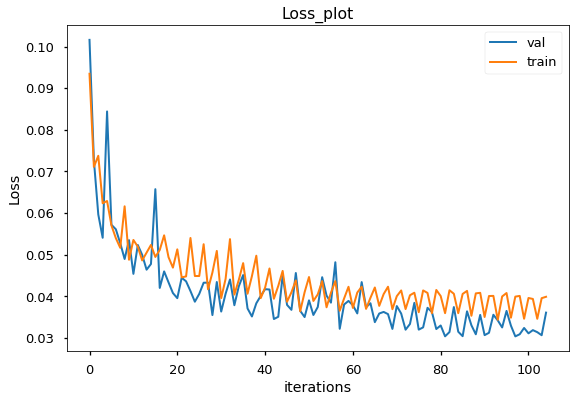

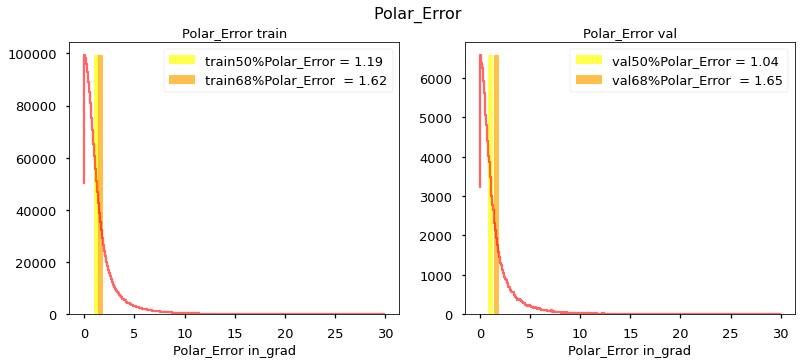

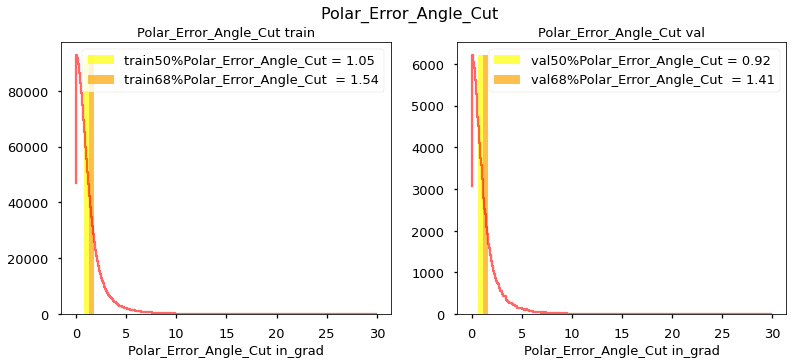

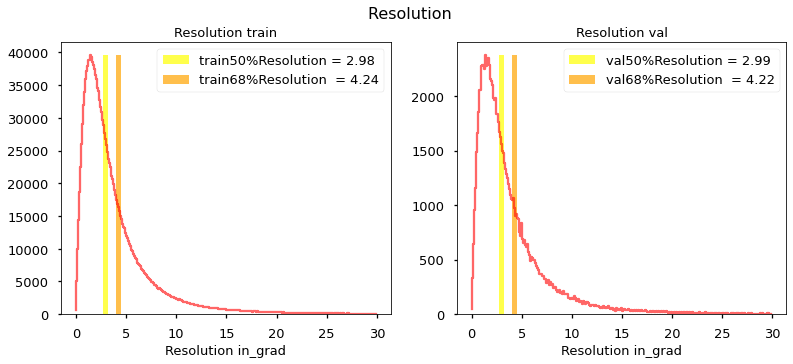

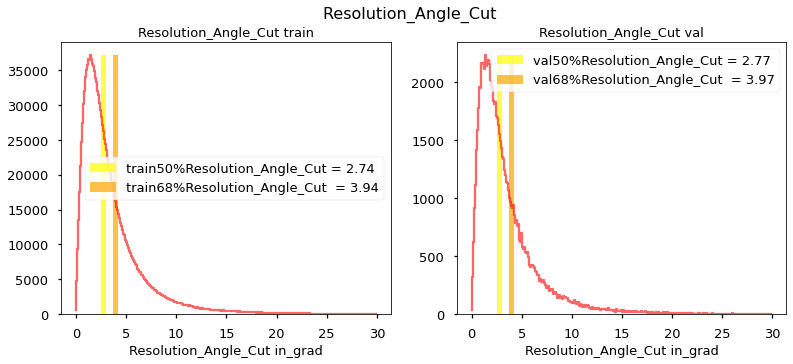

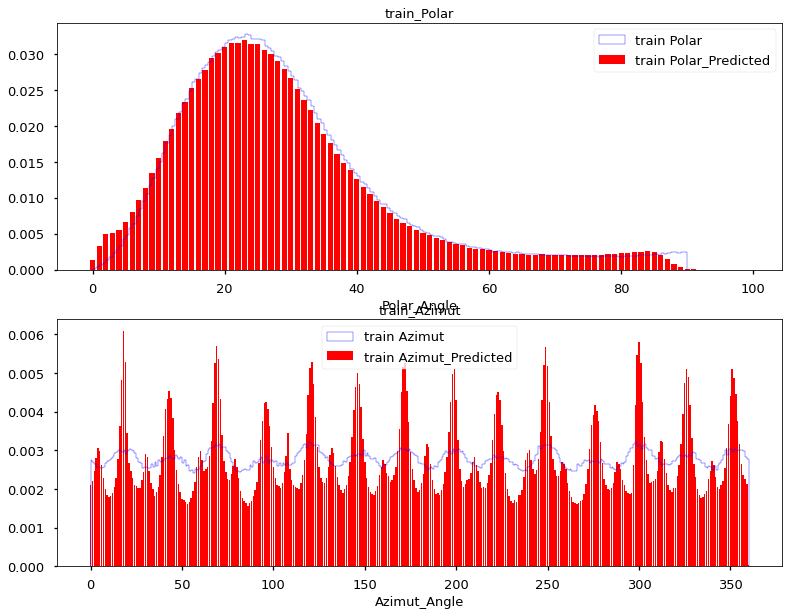

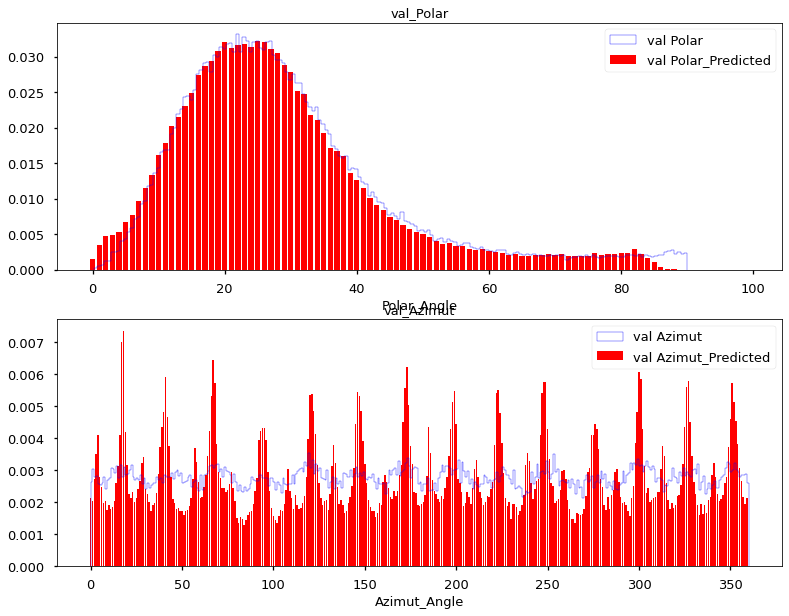

In [5]:
model = bigger_net.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[7,14,21,28,35], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger",
                                                                       epochs_num=35, batch_size =64)

# Selu

In [33]:
class ResNet_Block_Selu(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*2,  kernel_size=3, stride=1,padding=1,bias = False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.SELU(),
            torch.nn.Conv1d(input_size*2, input_size*2,  kernel_size=3, stride=1,padding=1, bias = False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.SELU(),
            torch.nn.Conv1d(input_size*2,input_size,  kernel_size=3, stride= 1 ,padding=1, bias = False),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.SELU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias = False),
            torch.nn.SELU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
class Transition_Block_Selu(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias = False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.SELU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
a = torch.ones((512,5 ,32))
bigger_net_selu = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1, bias = False ),
    torch.nn.BatchNorm1d(5),
    torch.nn.SELU(),
    ResNet_Block_Selu(5), #32
    ResNet_Block_Selu(5), 
    Transition_Block_Selu(5), #16
    ResNet_Block_Selu(10),
    ResNet_Block_Selu(10), #16
    Transition_Block_Selu(10), #8
    ResNet_Block_Selu(20),
    ResNet_Block_Selu(20), 
    Transition_Block_Selu(20), #4
    ResNet_Block_Selu(40),
    ResNet_Block_Selu(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.SELU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.SELU(),
    torch.nn.Linear(20 ,3)
) 


print(bigger_net_selu(a).shape )
sum(p.numel() for p in bigger_net_selu.parameters()   )

torch.Size([512, 3])


118568

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.09310423582792282   val_loss =  0.10352007113397121
Sub-epoch number =  12
train_loss =  0.07373012602329254   val_loss =  0.07451465539634228
Sub-epoch number =  24
train_loss =  0.07325127720832825   val_loss =  0.06319534732028842

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.07313591986894608   val_loss =  0.05525611620396376
Sub-epoch number =  48
train_loss =  0.06698676943778992   val_loss =  0.0578505489975214
Sub-epoch number =  60
train_loss =  0.06027466058731079   val_loss =  0.05615851143375039

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.06461898982524872   val_loss =  0.047904789447784424
Sub-epoch number =  84
train_loss =  0.061943527311086655   val_loss =  0.054416168946772814
Sub-epoch number =  96
train_loss =  0.06351261585950851   val_loss =  0.05287181679159403

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.052038200199604034   val_

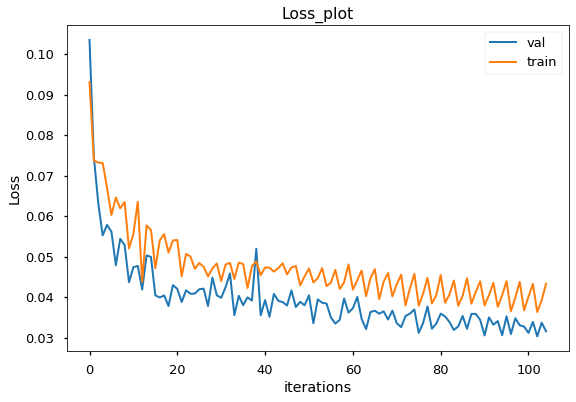

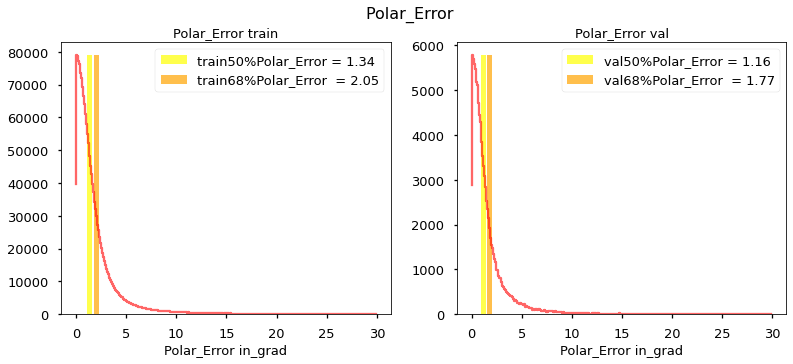

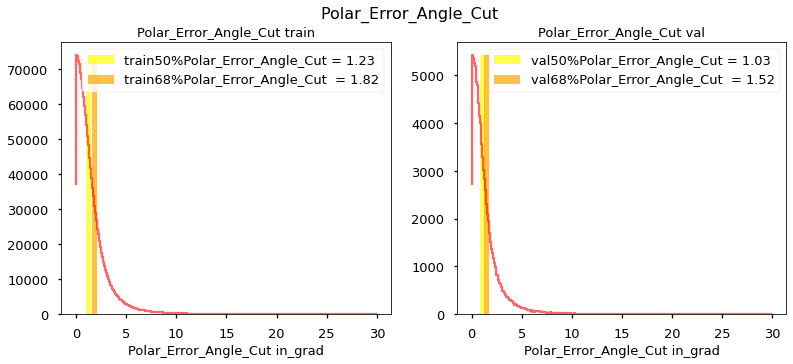

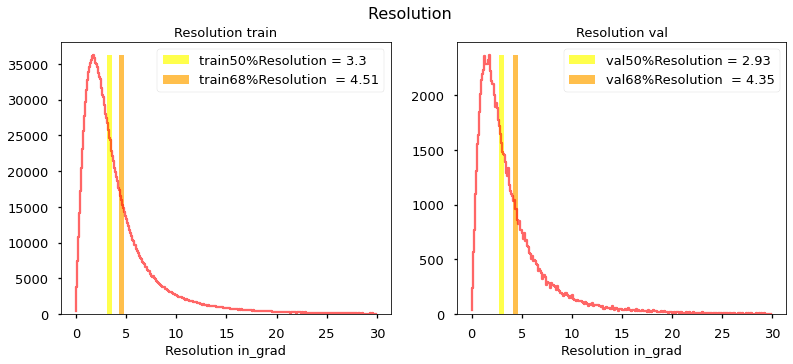

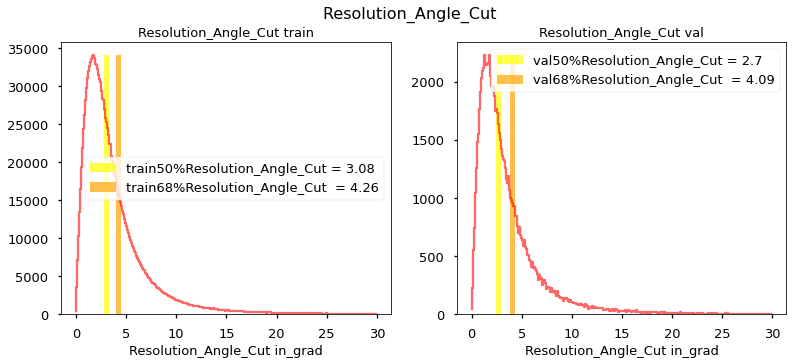

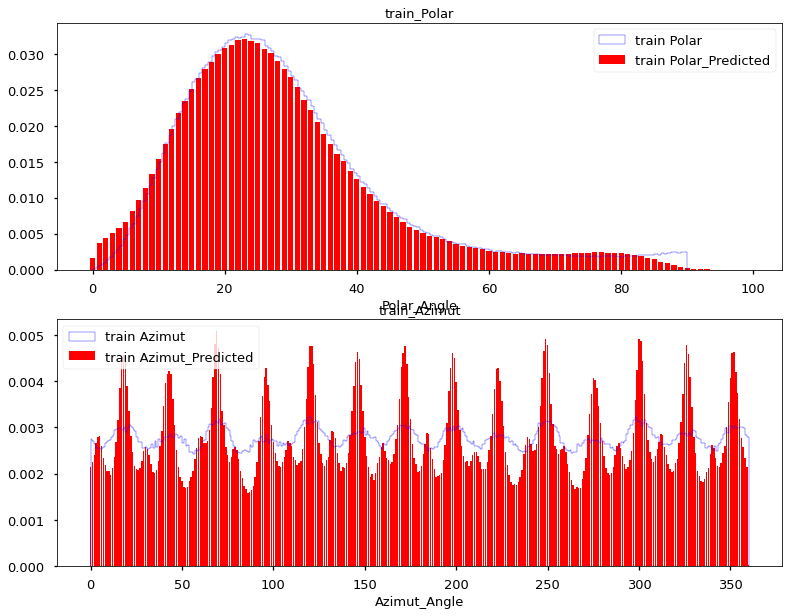

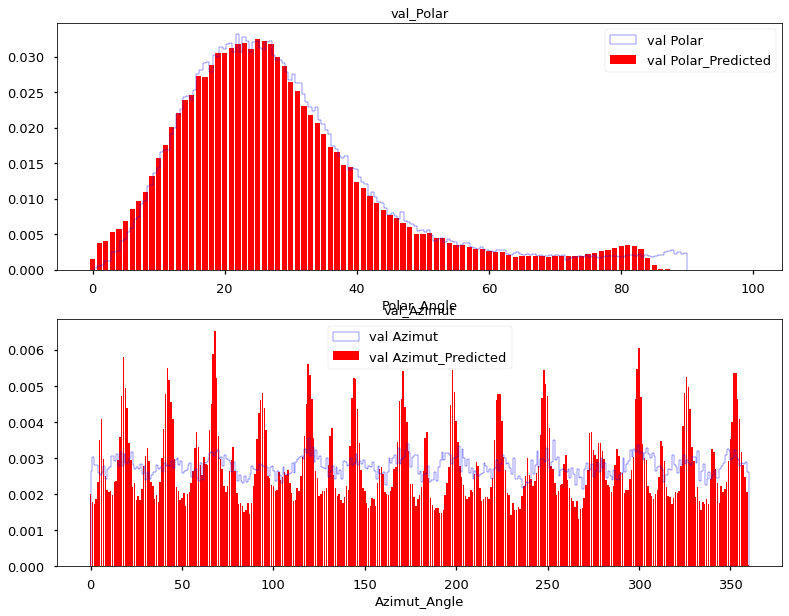

In [35]:
model = bigger_net_selu.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[7,14,21,28,35], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_selu",
                                                                       epochs_num=35, batch_size =64)

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.03669080138206482   val_loss =  0.030972155509516597
Sub-epoch number =  12
train_loss =  0.0397348590195179   val_loss =  0.03334467904642224
Sub-epoch number =  24
train_loss =  0.04251151531934738   val_loss =  0.03539366158656776

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.035929493606090546   val_loss =  0.0313619002699852
Sub-epoch number =  48
train_loss =  0.039689406752586365   val_loss =  0.03134566359221935
Sub-epoch number =  60
train_loss =  0.04262402653694153   val_loss =  0.03043584944680333

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.03602319955825806   val_loss =  0.0322403518948704
Sub-epoch number =  84
train_loss =  0.03931577876210213   val_loss =  0.0327125194016844
Sub-epoch number =  96
train_loss =  0.042511872947216034   val_loss =  0.0319719307590276

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.035621922463178635   val_los

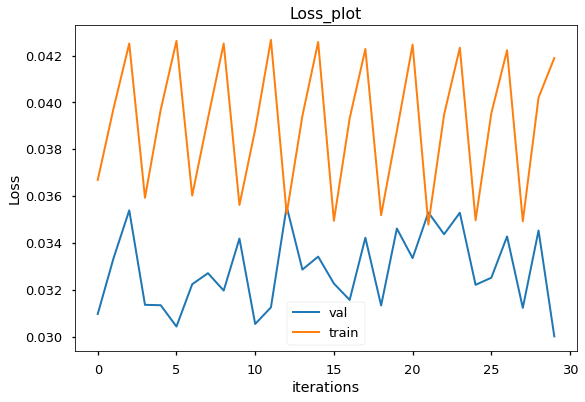

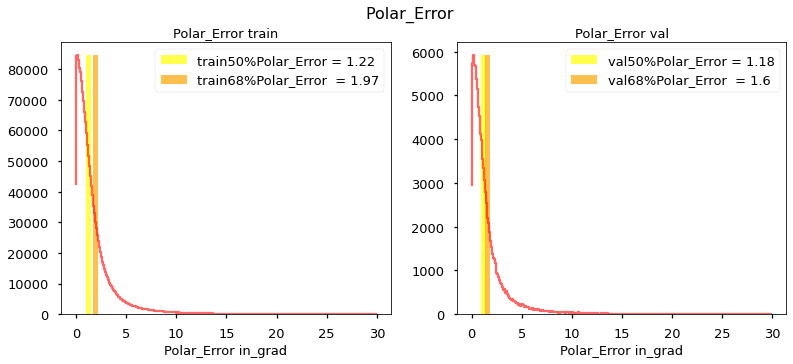

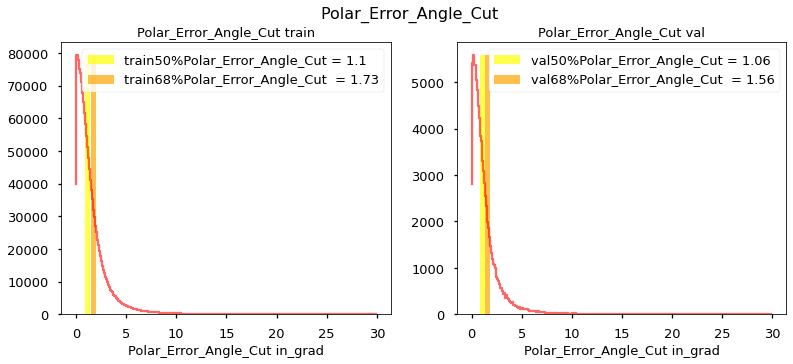

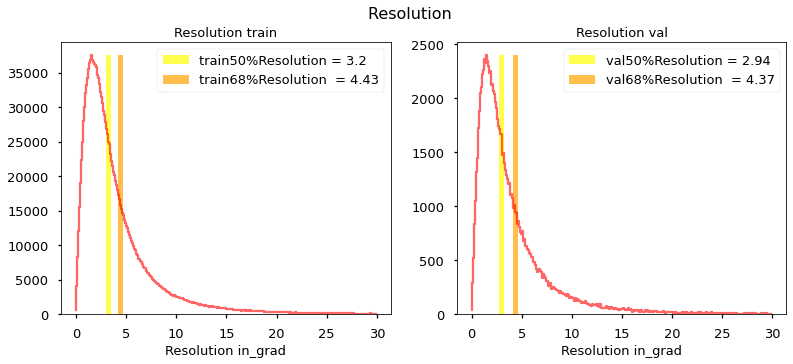

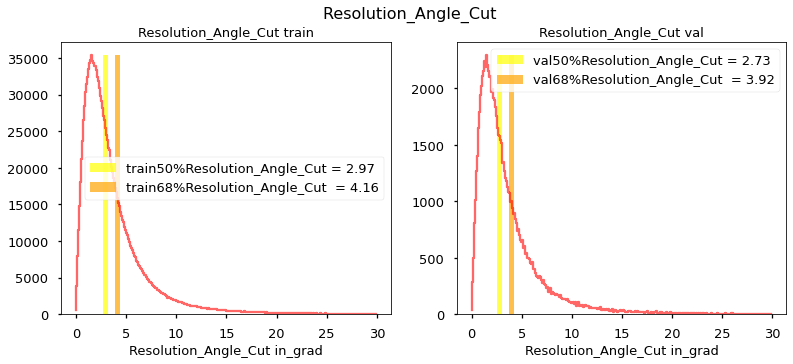

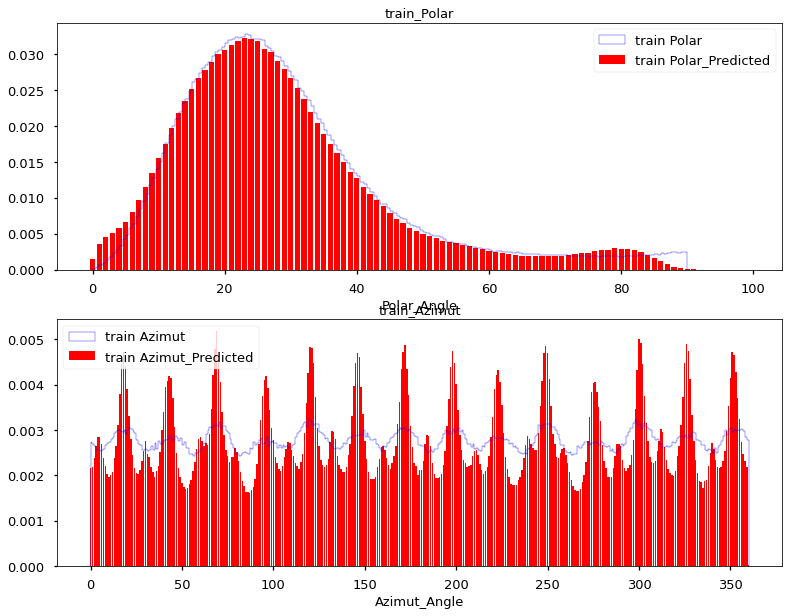

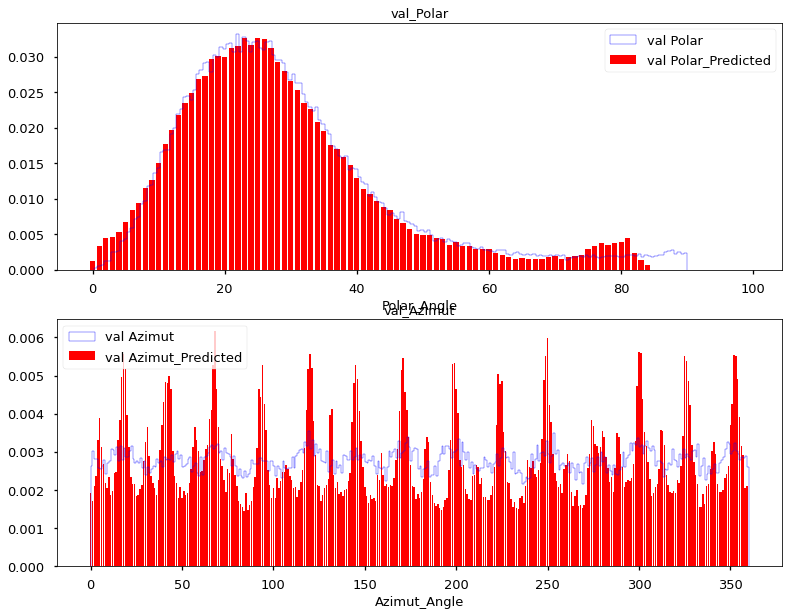

In [36]:

loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_selu_45epochs",
                                                                       epochs_num=10, batch_size =64)

# Worse Variants

# Just sum in resblock (selu)

In [55]:
class ResNet_Block_Selu(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*2,  kernel_size=3, stride=1,padding=1,bias = False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.SELU(),
            torch.nn.Conv1d(input_size*2, input_size*2,  kernel_size=3, stride=1,padding=1, bias = False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.SELU(),
            torch.nn.Conv1d(input_size*2,input_size,  kernel_size=3, stride= 1 ,padding=1, bias = False),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.SELU()
          )
        '''self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias = False),
            torch.nn.SELU()
        )'''
    def forward(self, inputs):
          return  self.module(inputs) +inputs
class Transition_Block_Selu(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias = False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.SELU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
a = torch.ones((512,5 ,32))
bigger_net_selu_sum = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1, bias = False ),
    torch.nn.BatchNorm1d(5),
    torch.nn.SELU(),
    ResNet_Block_Selu(5), #32
    ResNet_Block_Selu(5), 
    Transition_Block_Selu(5), #16
    ResNet_Block_Selu(10),
    ResNet_Block_Selu(10), #16
    Transition_Block_Selu(10), #8
    ResNet_Block_Selu(20),
    ResNet_Block_Selu(20), 
    Transition_Block_Selu(20), #4
    ResNet_Block_Selu(40),
    ResNet_Block_Selu(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.SELU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.SELU(),
    torch.nn.Linear(20 ,3)
) 


print(bigger_net_selu_sum(a).shape )
sum(p.numel() for p in bigger_net_selu_sum.parameters()   )

model = bigger_net_selu_sum.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[7,14,21,28,35], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_selu_sum",
                                                                       epochs_num=35, batch_size =64)

torch.Size([512, 3])


114318

Num of sub-epochs in Epoch =  9 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.033987708389759064   val_loss =  0.032906216103583574
Sub-epoch number =  3
train_loss =  0.03631574288010597   val_loss =  0.0324428731109947
Sub-epoch number =  6
train_loss =  0.03893199563026428   val_loss =  0.03275211434811354

 Indeed Epoch =  2
Sub-epoch number =  9
train_loss =  0.03447279334068298   val_loss =  0.03178739920258522
Sub-epoch number =  12
train_loss =  0.03655049204826355   val_loss =  0.03451082529500127
Sub-epoch number =  15
train_loss =  0.03893207758665085   val_loss =  0.03498861100524664

 Indeed Epoch =  3
Sub-epoch number =  18
train_loss =  0.03352758288383484   val_loss =  0.0335513895843178
Sub-epoch number =  21
train_loss =  0.03629189729690552   val_loss =  0.03597533283755183
Sub-epoch number =  24
train_loss =  0.03950085863471031   val_loss =  0.0312201464548707

 Indeed Epoch =  4
Sub-epoch number =  27
train_loss =  0.033068783581256866   val_loss =  

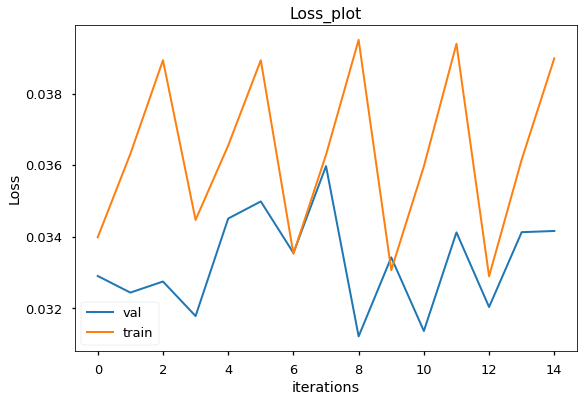

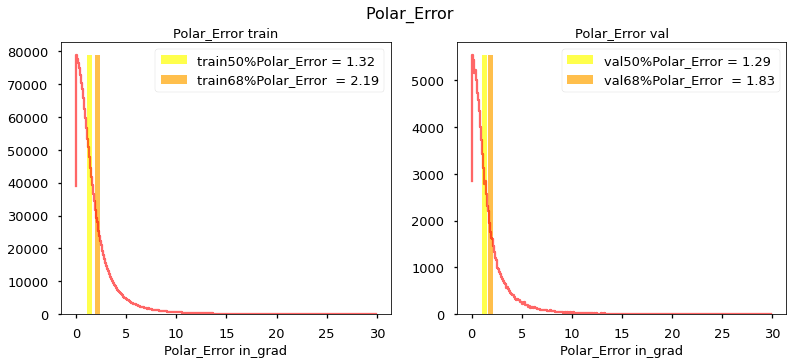

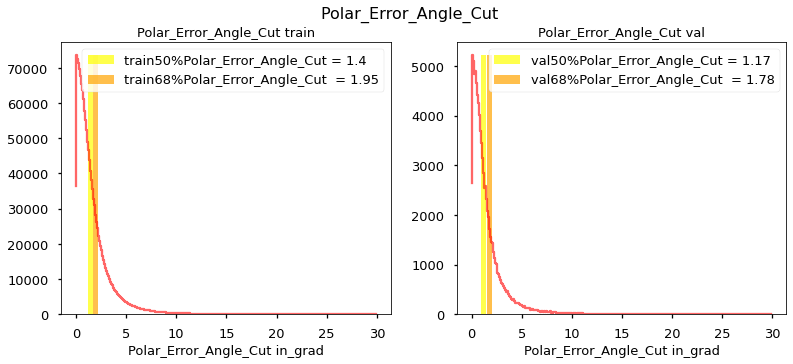

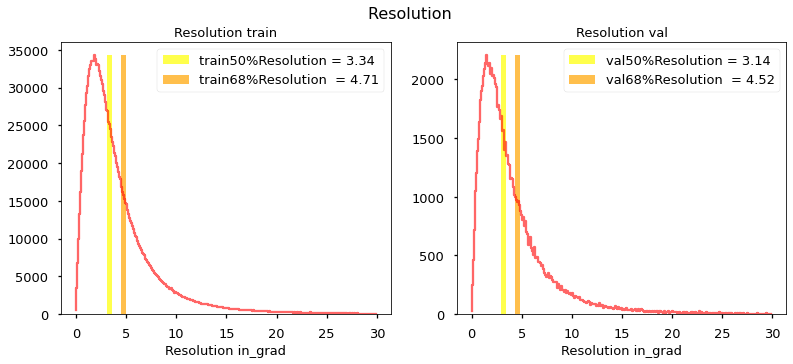

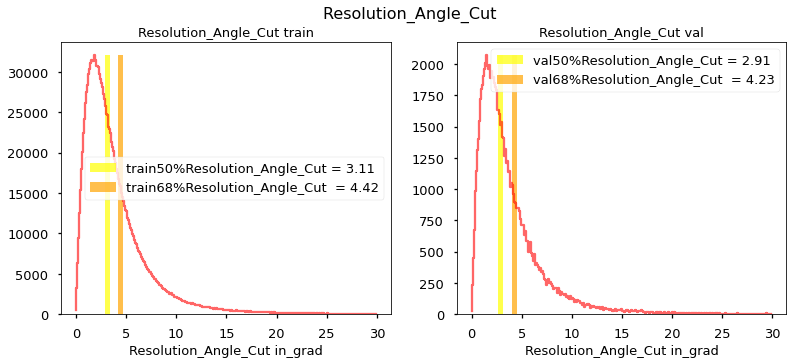

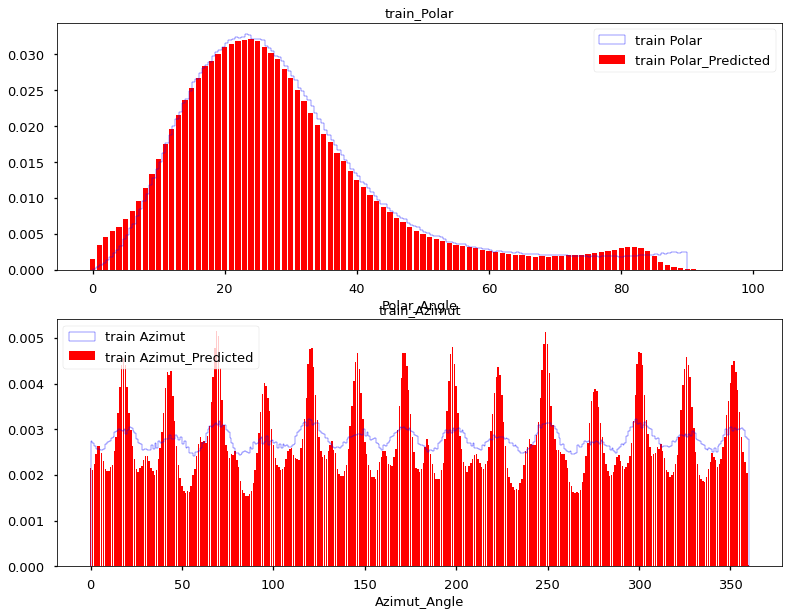

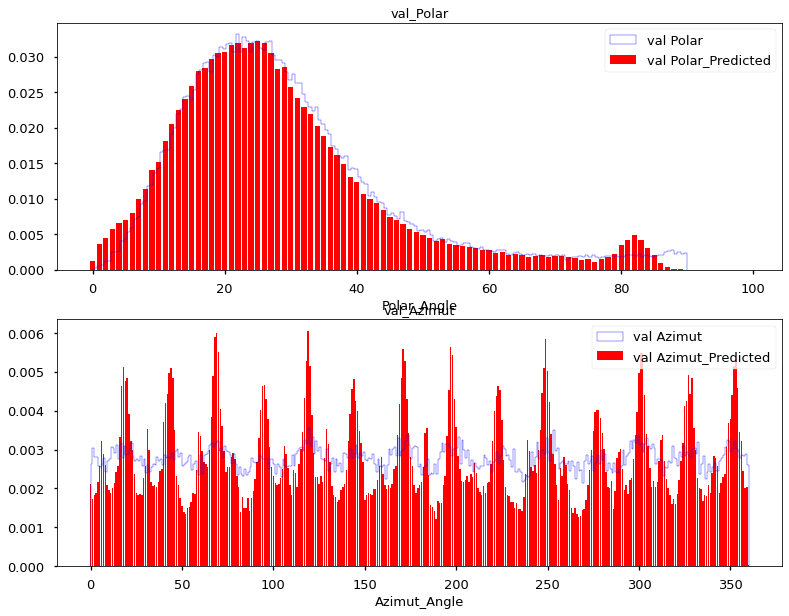

In [59]:
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_selu_sum_40epochs",
                                                                       epochs_num=5, batch_size =64)

# Bigger without bias

In [29]:
bias_mask = False

class ResNet_Block_no_bias(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*2,  kernel_size=3, stride=1,padding=1, bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2, input_size*2,  kernel_size=3, stride=1,padding=1, bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2,input_size,  kernel_size=3, stride= 1 ,padding=1, bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1, bias = bias_mask),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1, bias = bias_mask ),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 

a = torch.ones((512,5 ,32))
net_3_resblocks = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 , bias = bias_mask),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block_no_bias(5), #32
    ResNet_Block_no_bias(5),
    ResNet_Block_no_bias(5),
    Transition_Block(5), #16
    ResNet_Block_no_bias(10),
    ResNet_Block_no_bias(10),
    ResNet_Block_no_bias(10), #16
    Transition_Block(10), #8
    ResNet_Block_no_bias(20),
    ResNet_Block_no_bias(20),
    ResNet_Block_no_bias(20), 
    Transition_Block(20), #4
    ResNet_Block_no_bias(40),
    ResNet_Block_no_bias(40),
    ResNet_Block_no_bias(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    torch.nn.Linear(20 ,3)
) 


print(net_3_resblocks(a).shape )
sum(p.numel() for p in net_3_resblocks.parameters()   )

torch.Size([512, 3])


172497

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.08866779506206512   val_loss =  0.09397337678819895
Sub-epoch number =  12
train_loss =  0.07188443839550018   val_loss =  0.0672093671746552
Sub-epoch number =  24
train_loss =  0.07224728167057037   val_loss =  0.05936257913708687

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.06431078910827637   val_loss =  0.05941740982234478
Sub-epoch number =  48
train_loss =  0.06329020112752914   val_loss =  0.06452576024457812
Sub-epoch number =  60
train_loss =  0.06331875175237656   val_loss =  0.051200485322624445

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.05675050616264343   val_loss =  0.054305887315422297
Sub-epoch number =  84
train_loss =  0.06239708885550499   val_loss =  0.05603033024817705
Sub-epoch number =  96
train_loss =  0.059416815638542175   val_loss =  0.05052512465044856

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.05029768869280815   val_l

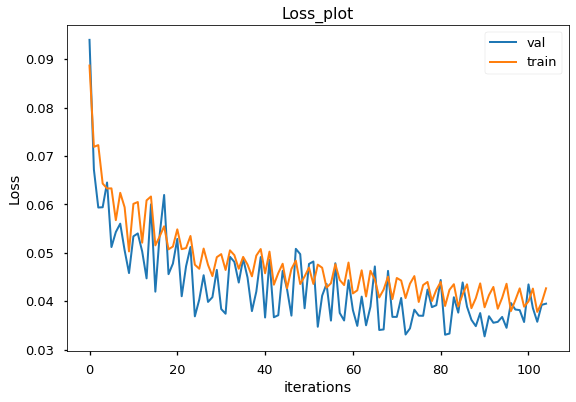

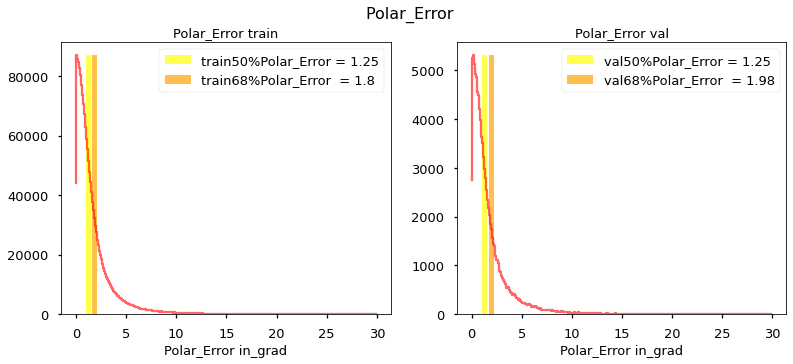

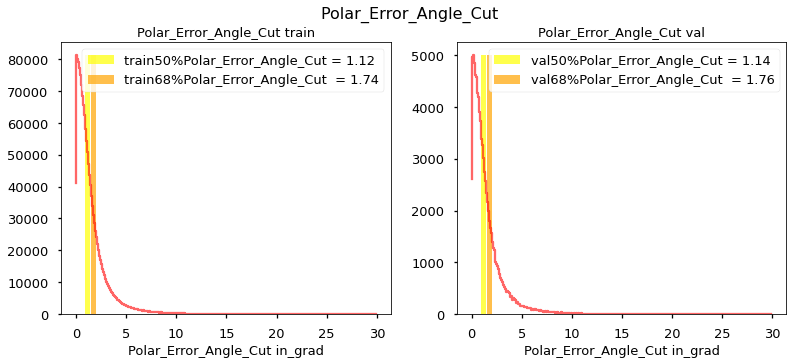

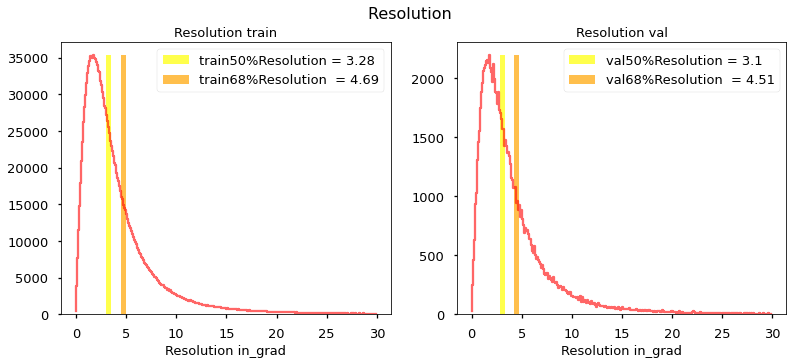

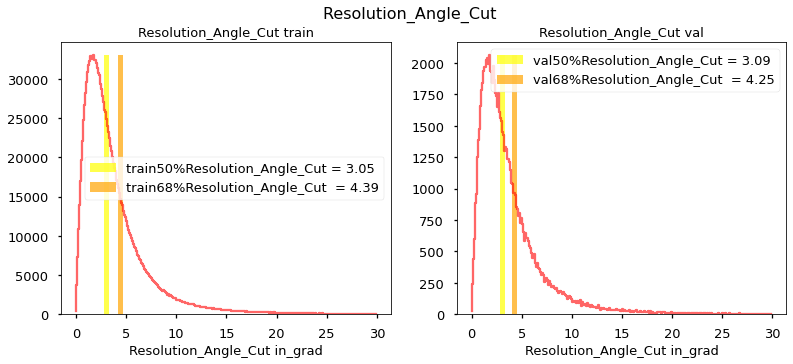

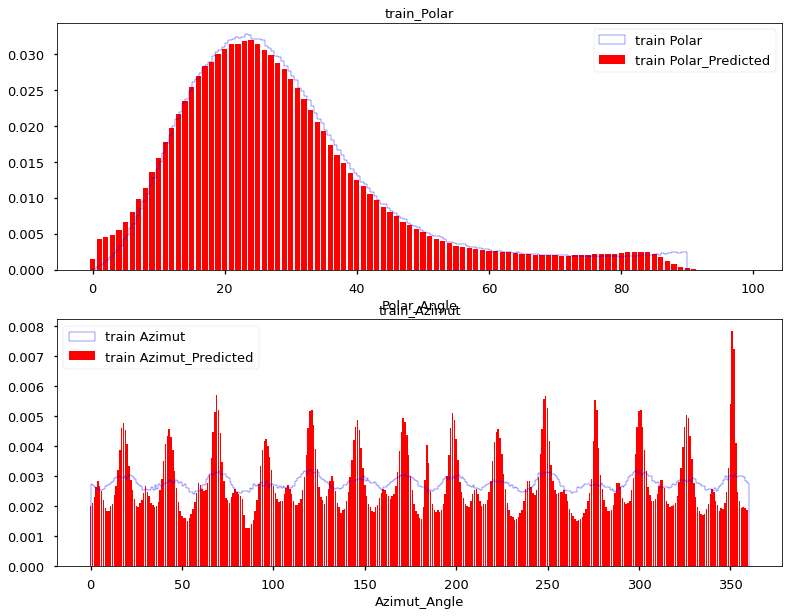

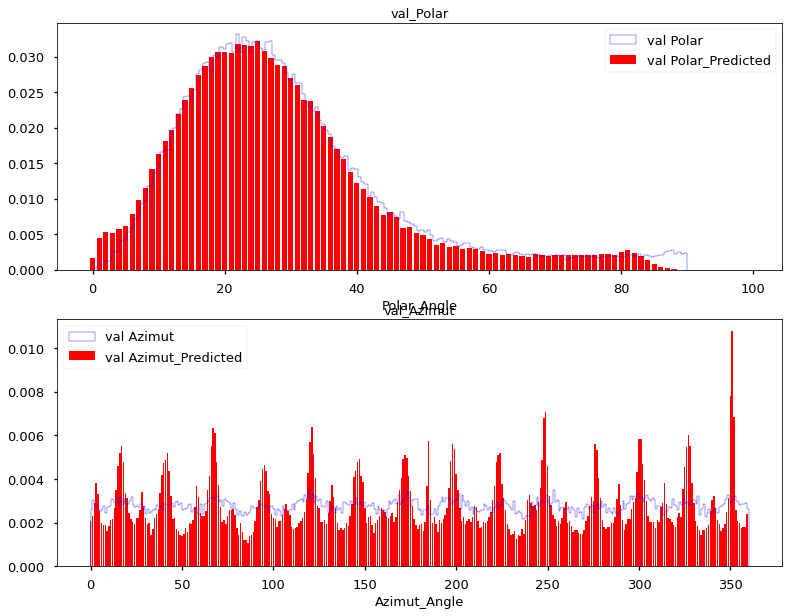

In [30]:
model = net.to(device)
learn_rate =4e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.97)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[7,14,21,28,35], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_3resblock",
                                                                       epochs_num=35, batch_size =64)

# Add batchnorm to transition


118911
Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.082966648042202   val_loss =  0.09808103926479816
Sub-epoch number =  12
train_loss =  0.07172955572605133   val_loss =  0.06594709912315011
Sub-epoch number =  24
train_loss =  0.06751822680234909   val_loss =  0.057503155432641506

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.06349405646324158   val_loss =  0.051053458359092474
Sub-epoch number =  48
train_loss =  0.06505253911018372   val_loss =  0.05782919283956289
Sub-epoch number =  60
train_loss =  0.06253361701965332   val_loss =  0.055257877334952354

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.0557185634970665   val_loss =  0.0506373206153512
Sub-epoch number =  84
train_loss =  0.0692438930273056   val_loss =  0.05030228290706873
Sub-epoch number =  96
train_loss =  0.06649048626422882   val_loss =  0.04720641113817692

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.0565524622797966   val

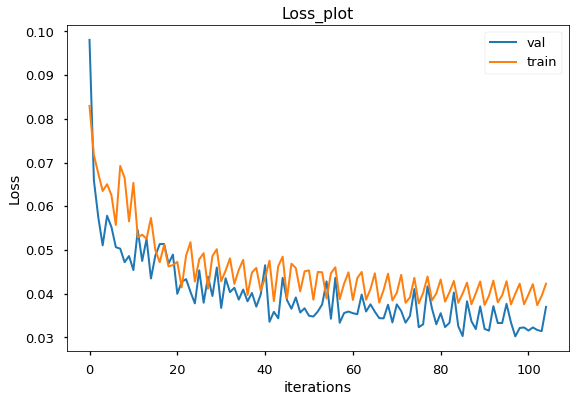

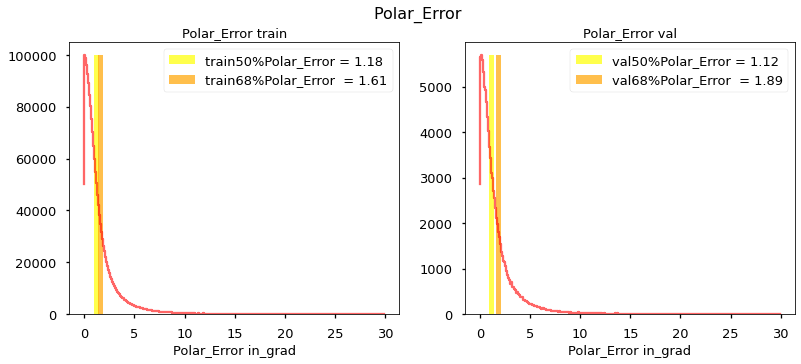

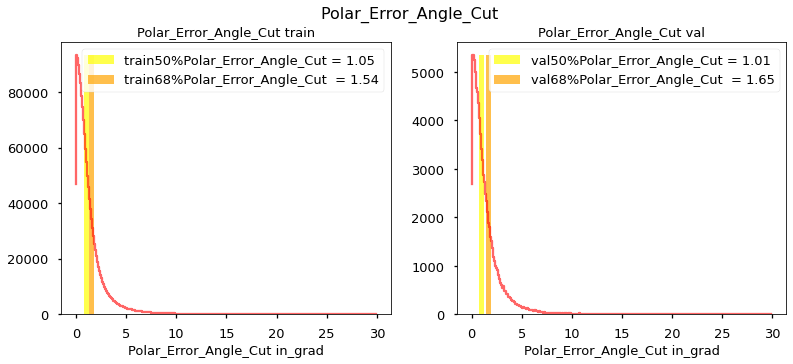

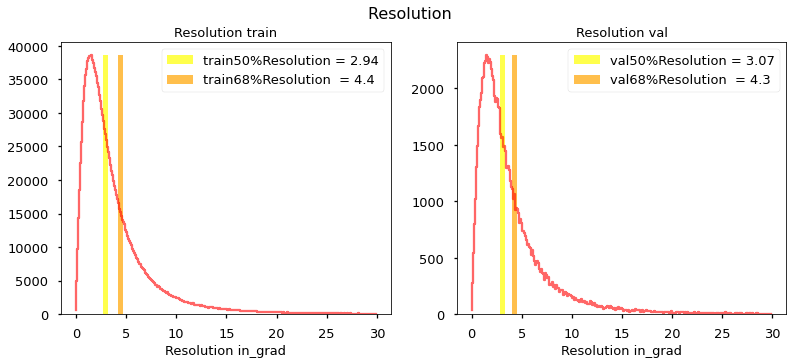

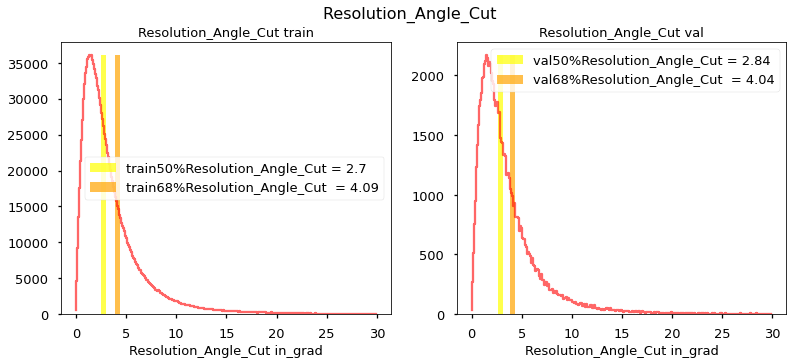

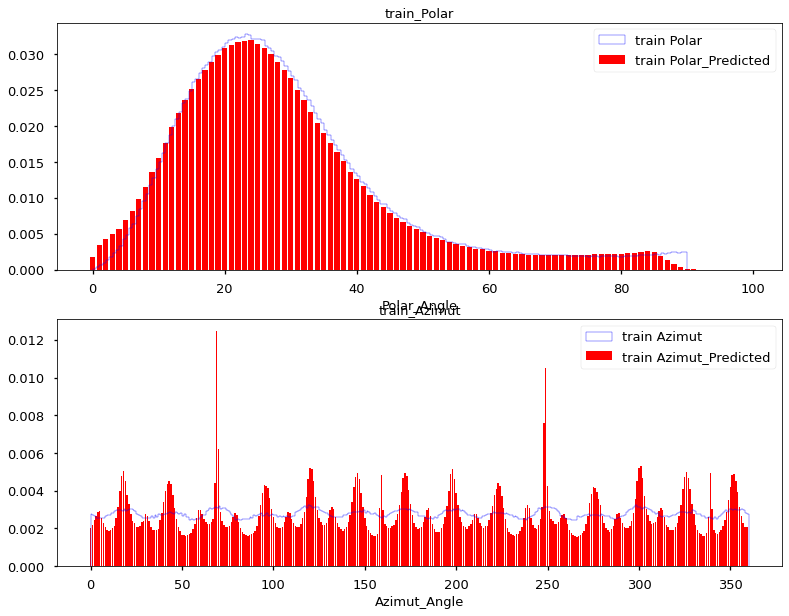

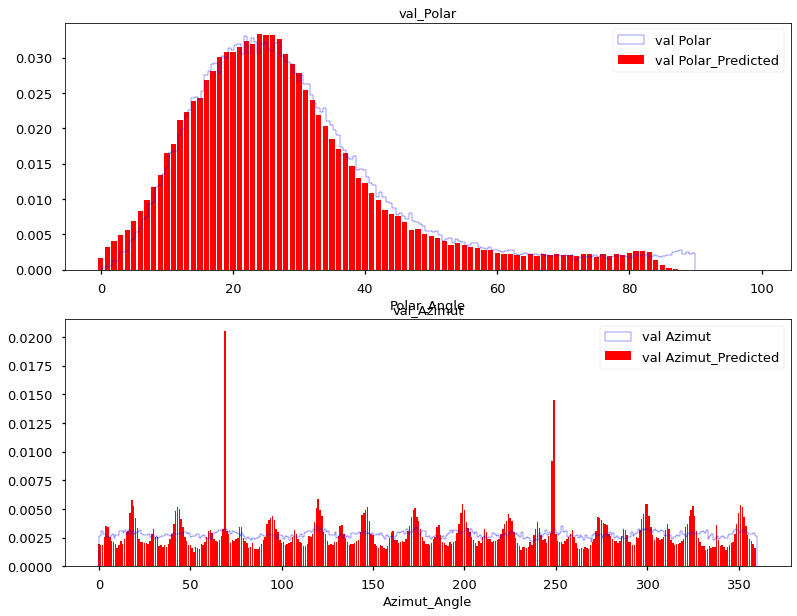

In [12]:
class ResNet_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*2,  kernel_size=3, stride=1,padding=1, bias =False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2, input_size*2,  kernel_size=3, stride=1,padding=1, bias =False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2,input_size,  kernel_size=3, stride= 1 ,padding=1, bias =False),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1, bias =False),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias =False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
    

#a = torch.ones((512,5 ,32))
bigger_net_updated = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block(5), #32
    ResNet_Block(5), 
    Transition_Block(5), #16
    ResNet_Block(10),
    ResNet_Block(10), #16
    Transition_Block(10), #8
    ResNet_Block(20),
    ResNet_Block(20), 
    Transition_Block(20), #4
    ResNet_Block(40),
    ResNet_Block(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    #torch.nn.GRUCell(input_size  =20,hidden_size = 20 , bias=True),
    #torch.nn.GRUCell(input_size  =20,hidden_size = 20 , bias=True),
    torch.nn.Linear(20 ,3)
) 


#net(a).shape
print(sum(p.numel() for p in bigger_net_updated.parameters()   ) )

model = bigger_net_updated.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[7,14,21,28,35], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_updated",
                                                                       epochs_num=35, batch_size =64)

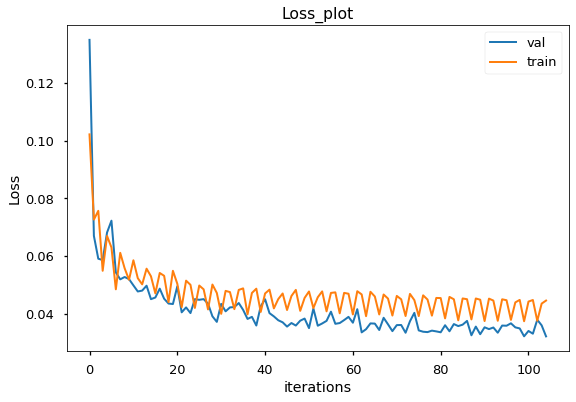

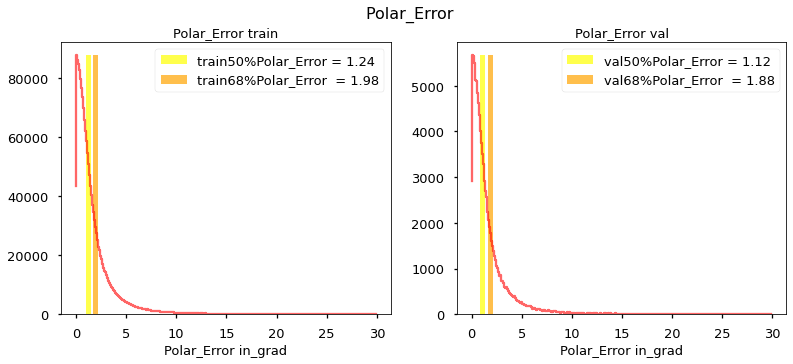

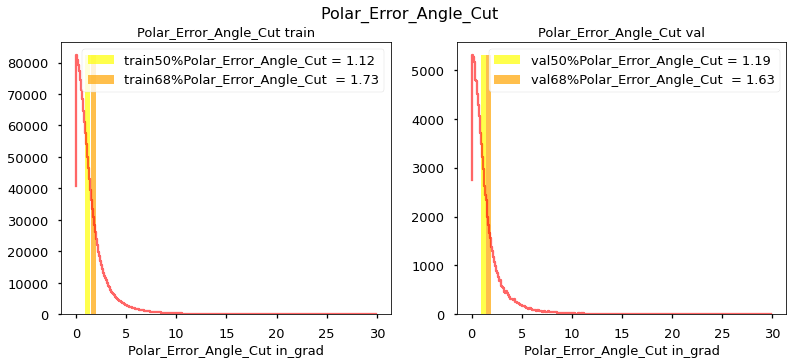

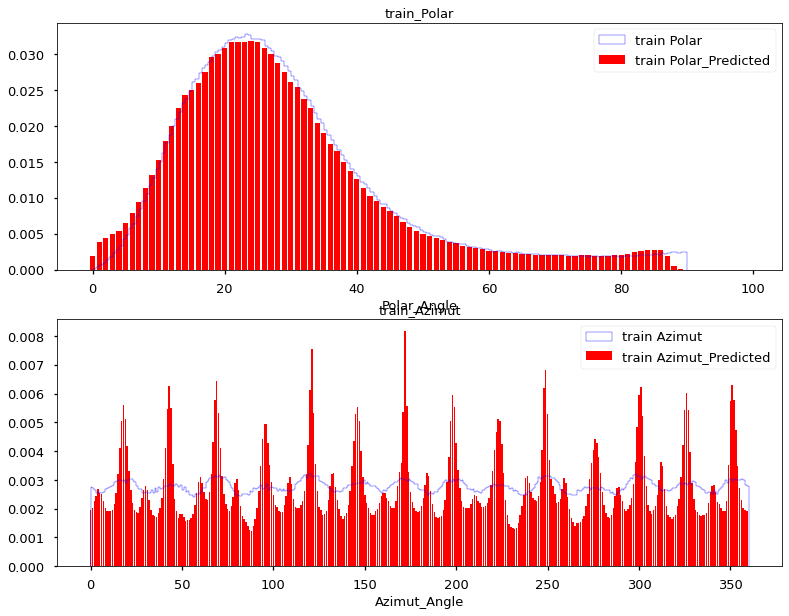

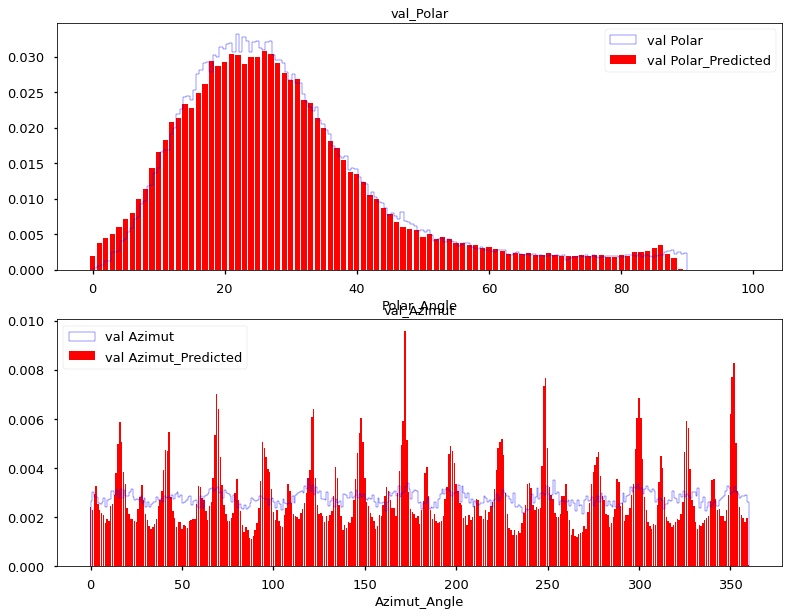

In [16]:
if True:
    suffix = "Nu_MAE_RNN_NORM"
    path_begin = "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered"
    # график лосса
    loss_plot(loss_lists[1], loss_lists[0] , path_begin + "/Images/Loss/" + suffix + "LOSS.png")
    
    #  гистограмма ошибок  полярного угла
    res_plot(polar_error[0], polar_error[1], 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Polar_Error.png",
              res_or_polar = "Polar_Error ")
 
    #  гистограмма ошибок  полярного угла для определенных углов
    res_plot(polar_error[2], polar_error[3],
             path = path_begin + "/Images/Polar_Error_Angle_Cut/" + suffix+ "Polar_Error_Angle_Cut.png",
             res_or_polar = "Polar_Error_Angle_Cut ")  

    #гистограммы углов
    angle_hist(polar_hists[0],azimut_hists[0], name='train',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_train.png"
               )
    angle_hist(polar_hists[1],azimut_hists[1], name='val',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_val.png"
               )

# ResNet with GRU at the end

In [41]:
class ResNet_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*2,  kernel_size=3, stride=1,padding=1, bias =False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2, input_size*2,  kernel_size=3, stride=1,padding=1, bias =False),
            torch.nn.BatchNorm1d(input_size*2),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*2,input_size,  kernel_size=3, stride= 1 ,padding=1, bias =False),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1, bias =False),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias =False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
    

#a = torch.ones((512,5 ,32))
bigger_net_updated_with_GRU = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block(5), #32
    ResNet_Block(5), 
    Transition_Block(5), #16
    ResNet_Block(10),
    ResNet_Block(10), #16
    Transition_Block(10), #8
    ResNet_Block(20),
    ResNet_Block(20), 
    Transition_Block(20), #4
    ResNet_Block(40),
    ResNet_Block(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    torch.nn.GRUCell(input_size  =20,hidden_size = 20 , bias=True),
    torch.nn.GRUCell(input_size  =20,hidden_size = 20 , bias=True),
    torch.nn.Linear(20 ,3)
) 


#net(a).shape
print(sum(p.numel() for p in bigger_net_updated_with_GRU.parameters()   ) )



123951


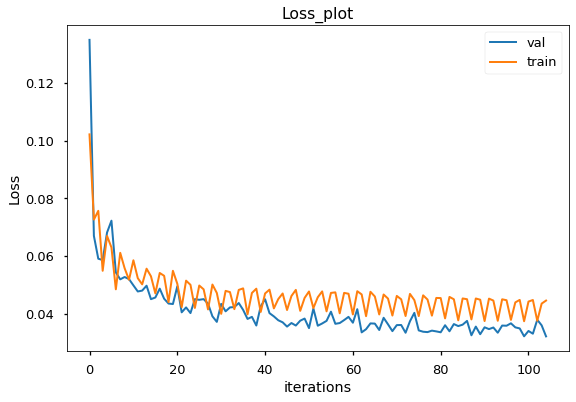

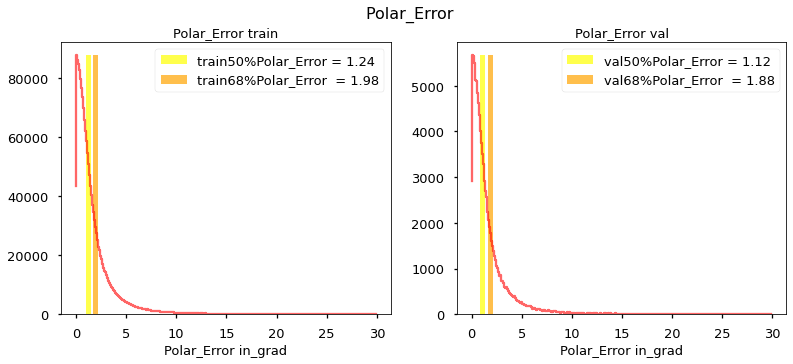

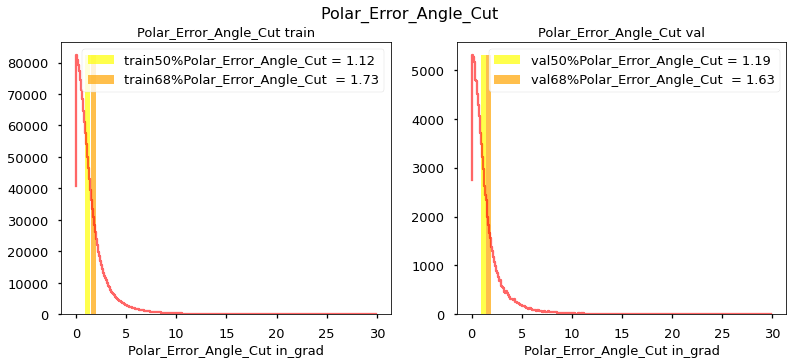

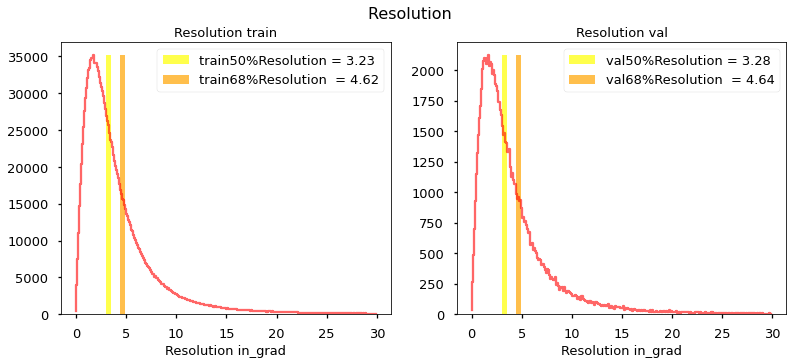

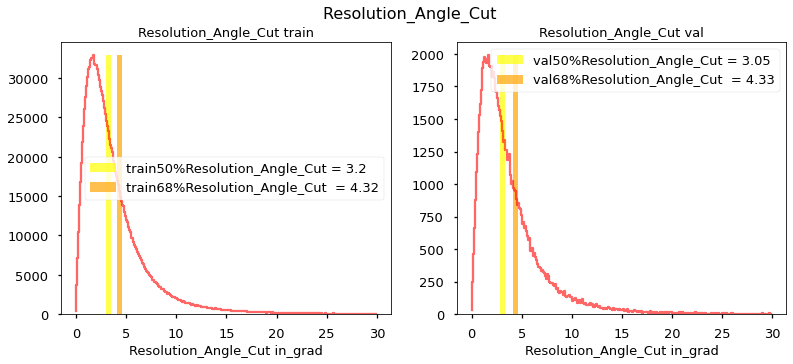

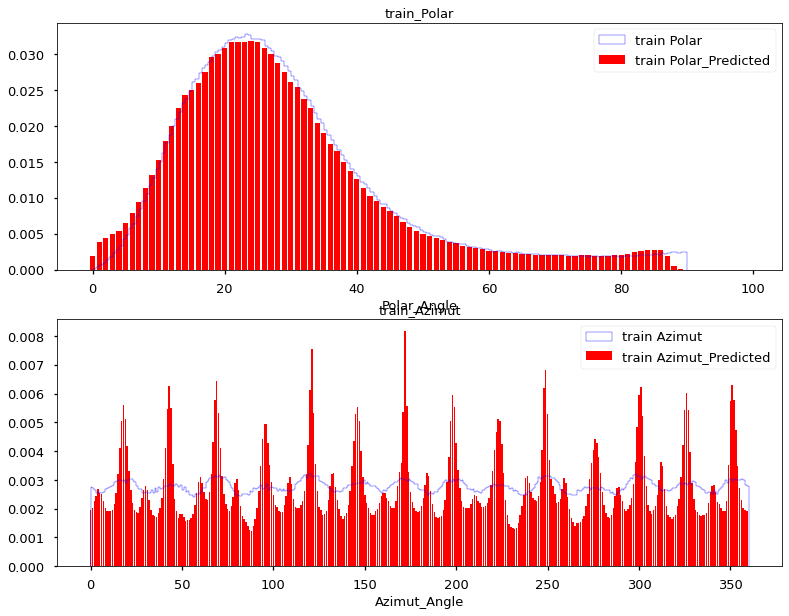

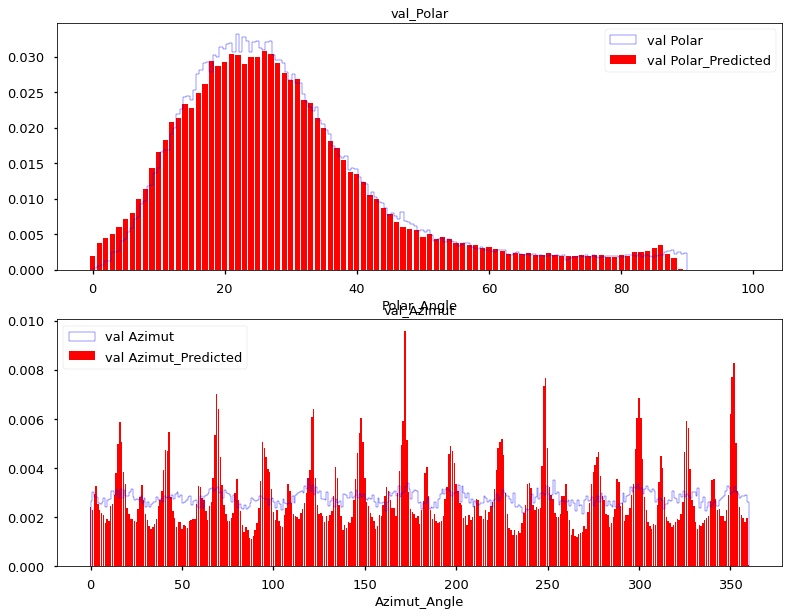

In [18]:
if True:
    suffix =  "Nu_MAE_Res_1D_bigger_with_GRU"
    path_begin = "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered"
# график лосса
    loss_plot(loss_lists[1], loss_lists[0] , path_begin + "/Images/Loss/" + suffix + "LOSS.png")
    
    #  гистограмма ошибок  полярного угла
    res_plot(polar_error[0], polar_error[1], 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Polar_Error.png",
              res_or_polar = "Polar_Error ")
 
    #  гистограмма ошибок  полярного угла для определенных углов
    res_plot(polar_error[2], polar_error[3],
             path = path_begin + "/Images/Polar_Error_Angle_Cut/" + suffix+ "Polar_Error_Angle_Cut.png",
             res_or_polar = "Polar_Error_Angle_Cut ")  
    
    # гистограммы разрешения
    res_plot(res_hists[0],res_hists[1],
             path = path_begin + "/Images/Resolution/" + suffix + "RESOLUTIONS.png",
             res_or_polar = "Resolution ")
    
    # гистограммы разрешения для определенных углов
    res_plot(res_hists[2],res_hists[3],
             path = path_begin + "/Images/Resolution_Angle_Cut/" + suffix + "Resolution_Angle_Cut.png",
             res_or_polar = "Resolution_Angle_Cut ")
    
    #гистограммы углов
    angle_hist(polar_hists[0],azimut_hists[0], name='train',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_train.png"
               )
    angle_hist(polar_hists[1],azimut_hists[1], name='val',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_val.png"
               )

In [ ]:
model = bigger_net_updated_with_GRU.to(device)
suffix =  "Nu_MAE_Res_1D_bigger_with_GRU"
path_begin = "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered"
PATH = path_begin + "/states/" + suffix + "model"
model.load_state_dict(torch.load(PATH))

opt = torch.optim.Adam(model.parameters(),lr=2e-2)
PATH = path_begin + "/states/" + suffix + "opt"
opt.load_state_dict(torch.load(PATH))


sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.975)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[7,14,21,28,35], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_with_GRU_45_epochs",
                                                                       epochs_num=10, batch_size =64,
                                                                     )

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.03727257624268532   val_loss =  0.035020492505282164
Sub-epoch number =  12
train_loss =  0.042471759021282196   val_loss =  0.03467868478037417
Sub-epoch number =  24
train_loss =  0.044501759111881256   val_loss =  0.035068954806774855

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.03737061470746994   val_loss =  0.03508217912167311
Sub-epoch number =  48
train_loss =  0.04221656173467636   val_loss =  0.033238083589822054


Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  12
train_loss =  0.04169115424156189   val_loss =  0.03374969004653394
nan torch is bad at acos calculation
Sub-epoch number =  24
train_loss =  0.04382598400115967   val_loss =  0.03603295283392072
nan torch is bad at acos calculation
nan torch is bad at acos calculation
nan torch is bad at acos calculation


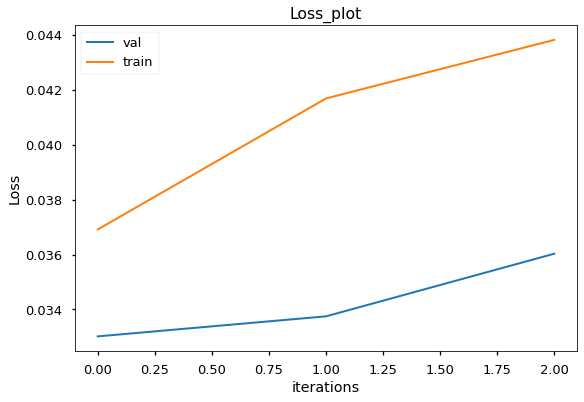

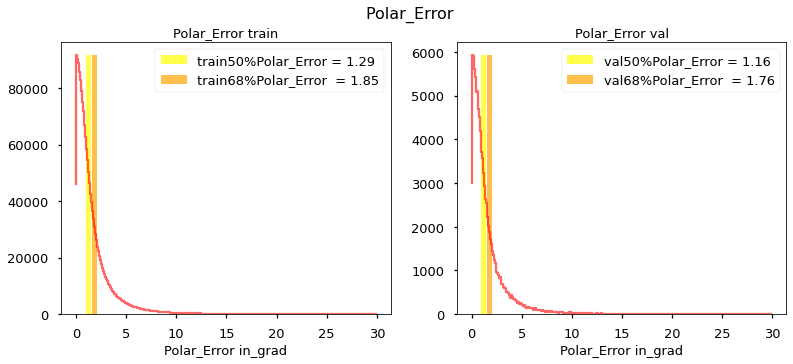

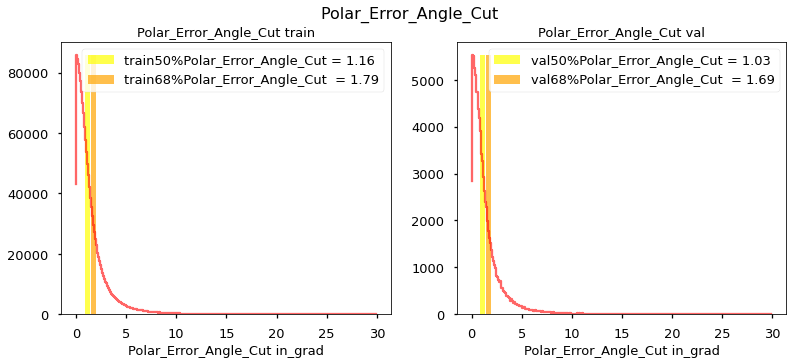

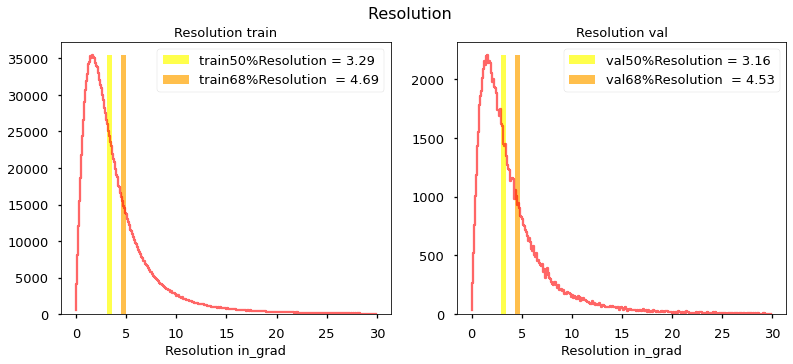

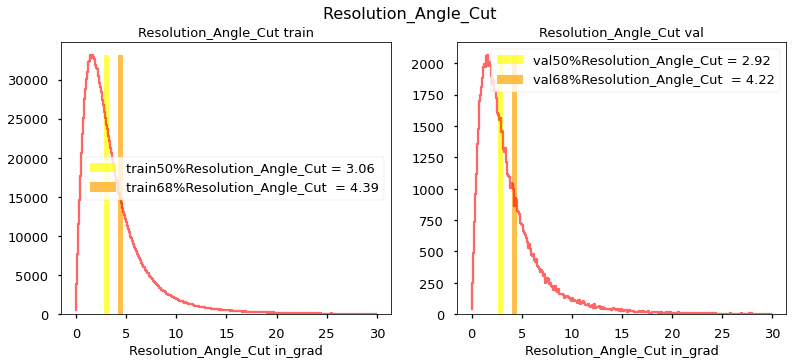

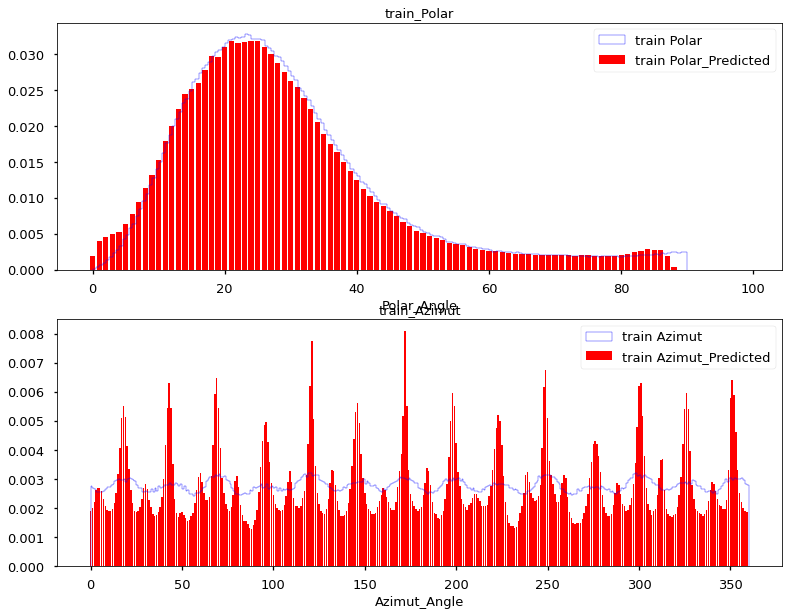

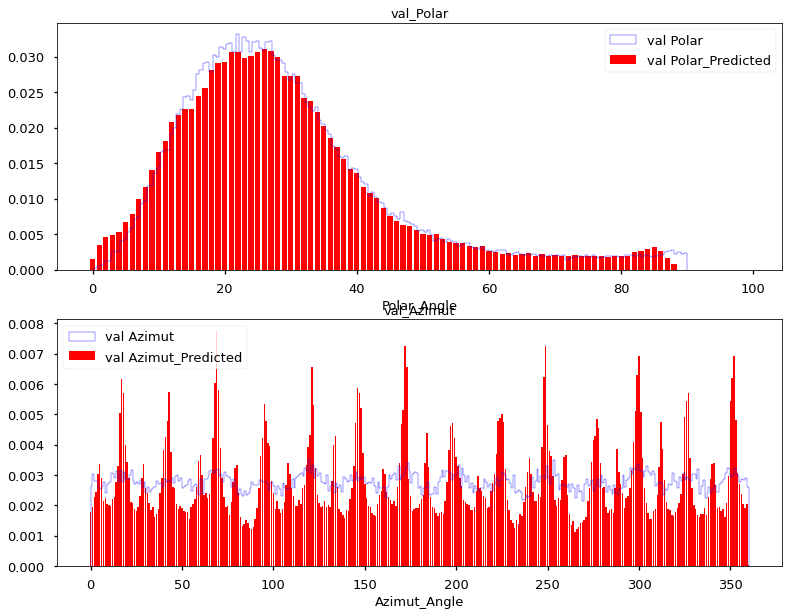

In [52]:
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_with_GRU_45_epochs",
                                                                       epochs_num=1, batch_size =64,
                                                                     )

# Simple

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.09293483942747116   val_loss =  0.08160771895200014
Sub-epoch number =  12
train_loss =  0.07241268455982208   val_loss =  0.06831832462921739
Sub-epoch number =  24
train_loss =  0.06845702230930328   val_loss =  0.055208591278642416

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.06054651737213135   val_loss =  0.0597795732319355
Sub-epoch number =  48
train_loss =  0.06593784689903259   val_loss =  0.06208833307027817
Sub-epoch number =  60
train_loss =  0.06773440539836884   val_loss =  0.052635225001722574

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.0516585111618042   val_loss =  0.05132688209414482
Sub-epoch number =  84
train_loss =  0.06108512729406357   val_loss =  0.052191019989550114
Sub-epoch number =  96
train_loss =  0.06066926568746567   val_loss =  0.04819843592122197

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.05216146633028984   val_lo

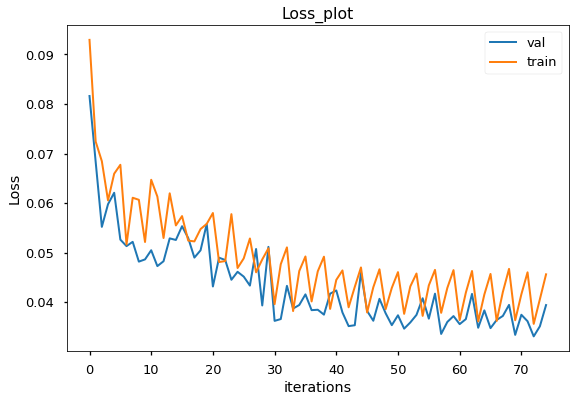

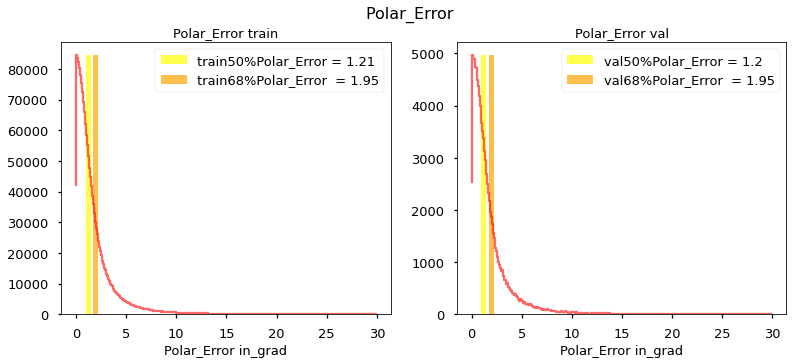

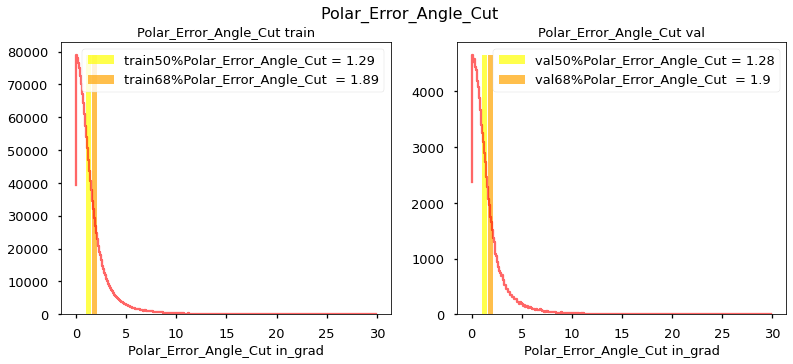

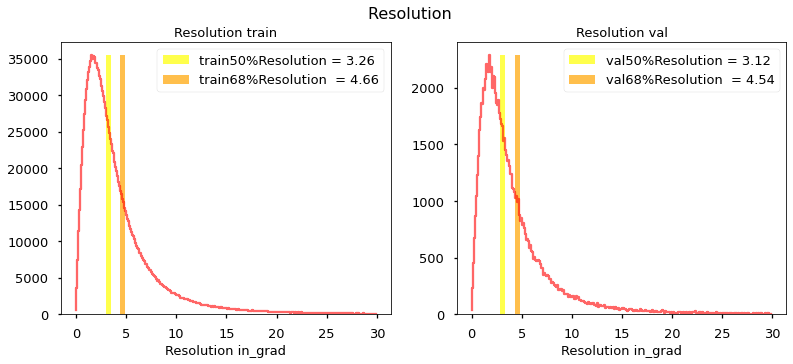

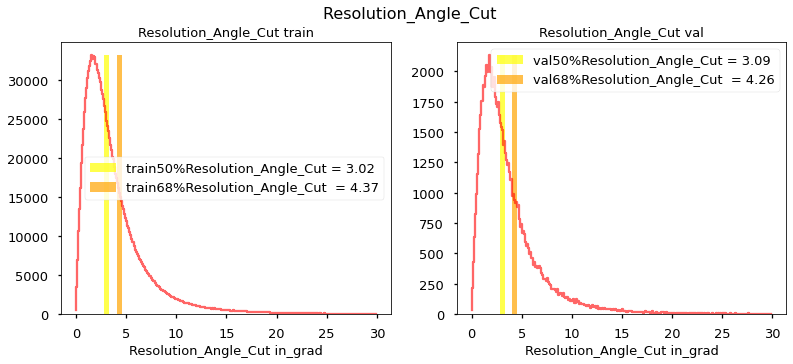

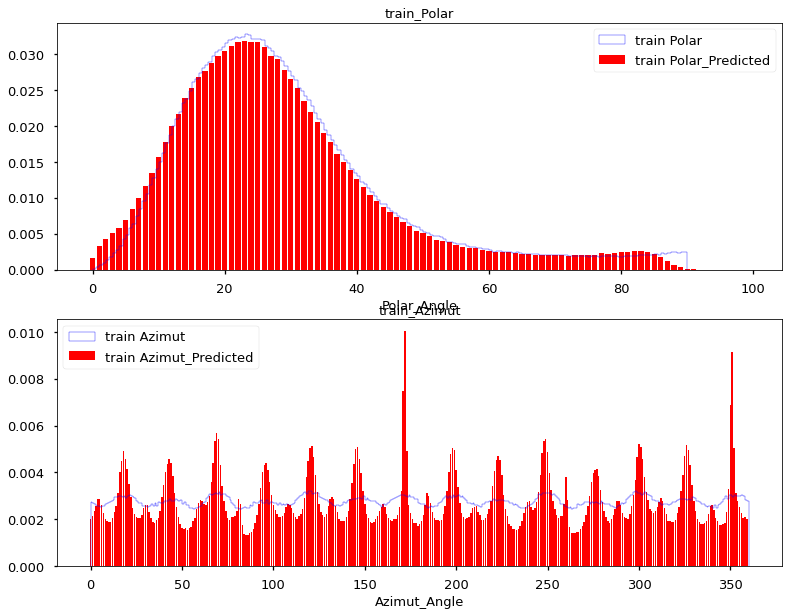

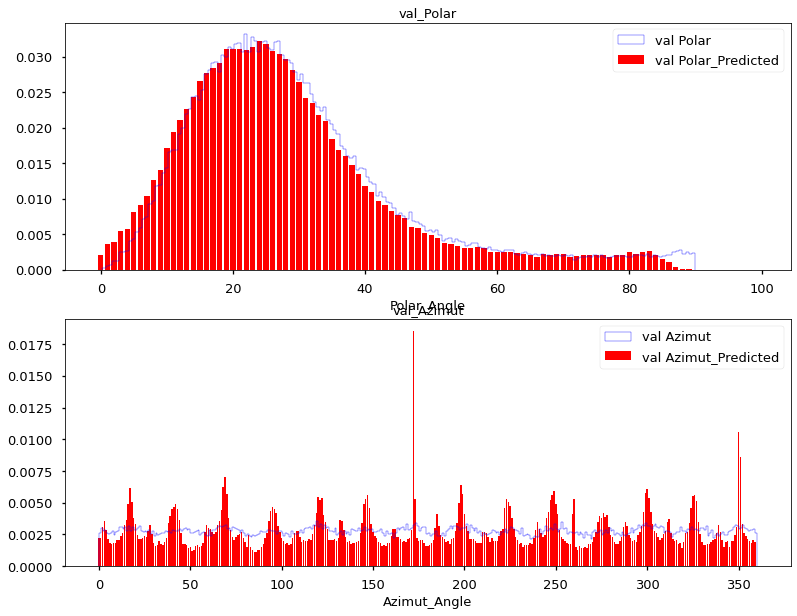

In [22]:
a = torch.ones((512,5 ,32))
net = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block(5), #32
    Transition_Block(5), #16
    ResNet_Block(10), #16
    Transition_Block(10), #8
    ResNet_Block(20),
    Transition_Block(20), #4
    ResNet_Block(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    torch.nn.Linear(20 ,3)
) 
#65240
print(net(a).shape)
sum(p.numel() for p in net.parameters()   )


model = net.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[10,20,30,40,45], gamma=0.7) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D",
                                                                       epochs_num=25, batch_size =64)

Num of sub-epochs in Epoch =  9 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.039020001888275146   val_loss =  0.03718641493469477
Sub-epoch number =  3
train_loss =  0.038368672132492065   val_loss =  0.03530591772869229
Sub-epoch number =  6
train_loss =  0.040533389896154404   val_loss =  0.03719361056573689

 Indeed Epoch =  2
Sub-epoch number =  9
train_loss =  0.038703422993421555   val_loss =  0.03815222671255469
Sub-epoch number =  12
train_loss =  0.03789607807993889   val_loss =  0.038233946077525616
Sub-epoch number =  15
train_loss =  0.040239471942186356   val_loss =  0.040705121122300625

 Indeed Epoch =  3
Sub-epoch number =  18
train_loss =  0.03902739658951759   val_loss =  0.03943157056346536
Sub-epoch number =  21
train_loss =  0.03778207302093506   val_loss =  0.03243095218203962
Sub-epoch number =  24
train_loss =  0.040106430649757385   val_loss =  0.03401991352438927

 Indeed Epoch =  4
Sub-epoch number =  27
train_loss =  0.03901911526918411   val_

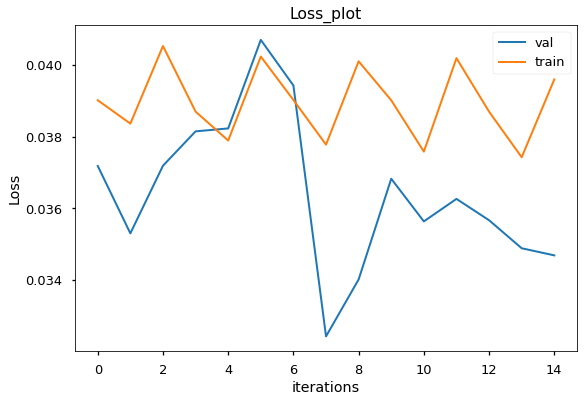

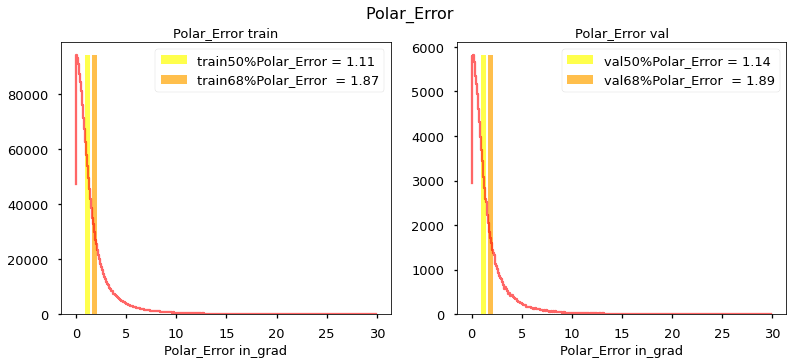

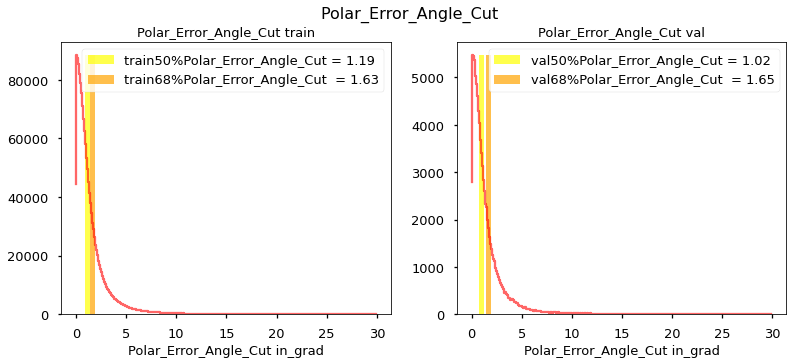

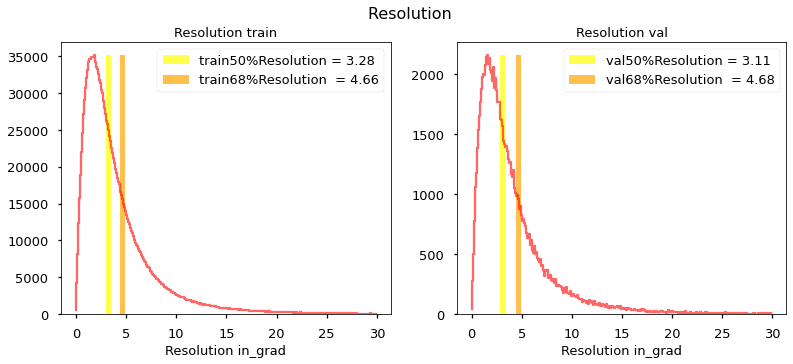

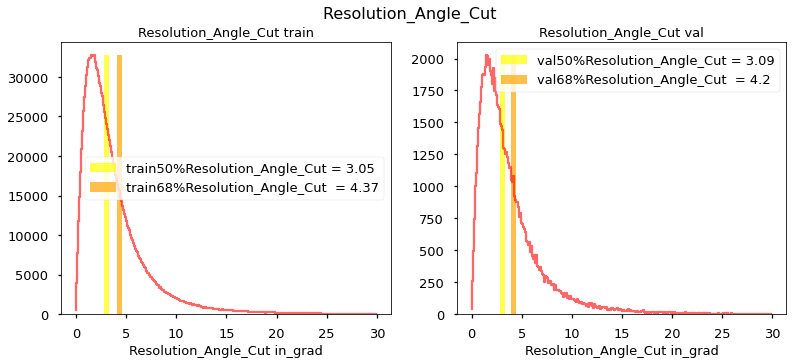

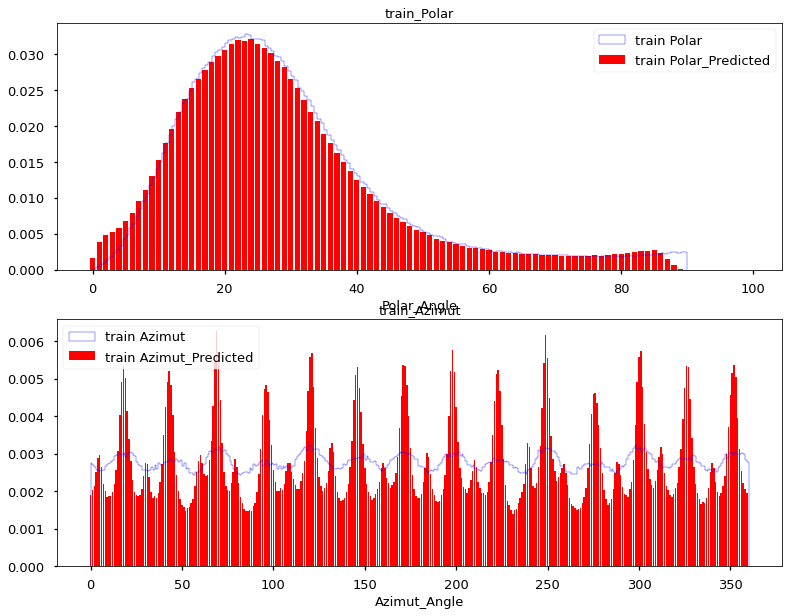

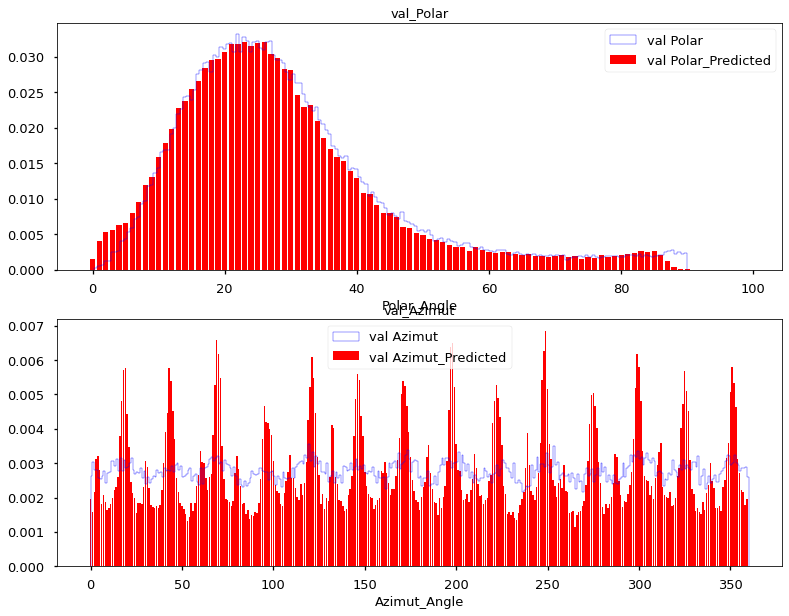

In [5]:
a = torch.ones((512,5 ,32))
bigger_net_simple = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block(5), #32
    ResNet_Block(5), 
    Transition_Block(5), #16
    ResNet_Block(10),
    ResNet_Block(10), #16
    Transition_Block(10), #8
    ResNet_Block(20),
    ResNet_Block(20), 
    Transition_Block(20), #4
    ResNet_Block(40),
    ResNet_Block(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,3)

) 


print(bigger_net_simple(a).shape )
sum(p.numel() for p in bigger_net_simple.parameters()   )

model = bigger_net_simple.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_bigger_simple_40epoch",
                                                                       epochs_num=35, batch_size =64)